In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully.")

Mounted at /content/drive
Google Drive mounted successfully.


In [2]:
# @title A. Mount Drive and Define Paths
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os

base_project_path = '/content/drive/MyDrive/NLPS1/'
cleaned_data_folder = os.path.join(base_project_path, 'Cleaned/')

# Xitsonga paths
xitsonga_cleaned_folder = os.path.join(cleaned_data_folder, 'cleanedXi/')
xitsonga_train_file = os.path.join(xitsonga_cleaned_folder, 'train_cleaned.csv')
xitsonga_val_file = os.path.join(xitsonga_cleaned_folder, 'dev_cleaned.csv')
xitsonga_test_file = os.path.join(xitsonga_cleaned_folder, 'test_cleaned.csv')

# Sesotho
sesotho_new_cleaned_file = os.path.join(cleaned_data_folder, 'sesotho_cleaned.csv')

# Setswana
setswana_new_cleaned_file = os.path.join(cleaned_data_folder, 'setswana_cleaned.csv')

print("Paths defined.")
print(f"NEW Sesotho cleaned exists: {os.path.exists(sesotho_new_cleaned_file)}")
print(f"NEW Setswana cleaned exists: {os.path.exists(setswana_new_cleaned_file)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Paths defined.
NEW Sesotho cleaned exists: True
NEW Setswana cleaned exists: True


In [3]:
# @title B. Load Libraries for Baseline Modeling
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Libraries for baseline modeling imported.")

Libraries for baseline modeling imported.


In [4]:
# @title C.1: Load and Prepare XITSOGA Data for Baselines

print("--- Preparing Xitsonga Data for Baselines ---")

try:
    df_train_xi = pd.read_csv(xitsonga_train_file)
    df_val_xi = pd.read_csv(xitsonga_val_file)
    df_test_xi = pd.read_csv(xitsonga_test_file)
    print("Xitsonga train, val (dev), and test CSVs loaded.")

    # Define the mapping for sentiment labels to numbers

    label_map_baseline = {'negative': 0, 'neutral': 1, 'positive': 2}
    # For printing results later
    numeric_to_sentiment_map_baseline = {v: k for k, v in label_map_baseline.items()}


    # Function to process each DataFrame (clean text column name, map labels)
    def process_df_for_baseline(df, text_col_original, sentiment_col_original, label_map):
        if text_col_original not in df.columns:
            print(f"ERROR: Text column '{text_col_original}' not found. Available: {df.columns.tolist()}")
            return None, None
        if sentiment_col_original not in df.columns:
            print(f"ERROR: Sentiment column '{sentiment_col_original}' not found. Available: {df.columns.tolist()}")
            return None, None

        df_processed = df.copy()
        df_processed['text'] = df_processed[text_col_original].fillna('')
        df_processed['sentiment_text_original'] = df_processed[sentiment_col_original].astype(str).str.lower().str.strip()
        df_processed['label'] = df_processed['sentiment_text_original'].map(label_map)

        # Drop rows where label mapping failed  or original text was NaN
        df_processed.dropna(subset=['label', 'text'], inplace=True)
        df_processed['label'] = df_processed['label'].astype(int)
        return df_processed['text'], df_processed['label']

    # Process each Xitsonga DataFrame

    X_train_xi, y_train_xi = process_df_for_baseline(df_train_xi, 'cleaned_text', 'sentiment', label_map_baseline)
    X_val_xi, y_val_xi = process_df_for_baseline(df_val_xi, 'cleaned_text', 'sentiment', label_map_baseline)
    X_test_xi, y_test_xi = process_df_for_baseline(df_test_xi, 'cleaned_text', 'sentiment', label_map_baseline)

    if X_train_xi is not None:
        print("\nXitsonga data prepared for baseline modeling:")
        print(f"Training examples: {len(X_train_xi)}")
        print(f"Validation examples: {len(X_val_xi)}")
        print(f"Test examples: {len(X_test_xi)}")
        print("\nSample of prepared training data (Xitsonga):")
        print("Text:", X_train_xi.head().tolist())
        print("Labels:", y_train_xi.head().tolist())
    else:
        print("Error in preparing Xitsonga data.")

except FileNotFoundError:
    print(f"ERROR: One or more Xitsonga cleaned files not found. Check paths in Cell A.")
    print(f"Searched for: {xitsonga_train_file}, {xitsonga_val_file}, {xitsonga_test_file}")
    X_train_xi, y_train_xi, X_val_xi, y_val_xi, X_test_xi, y_test_xi = [None]*6
except Exception as e:
    print(f"An unexpected error occurred while preparing Xitsonga data: {e}")
    X_train_xi, y_train_xi, X_val_xi, y_val_xi, X_test_xi, y_test_xi = [None]*6

--- Preparing Xitsonga Data for Baselines ---
Xitsonga train, val (dev), and test CSVs loaded.

Xitsonga data prepared for baseline modeling:
Training examples: 804
Validation examples: 203
Test examples: 254

Sample of prepared training data (Xitsonga):
Text: ['loku u navela ku tissunga tissungue🕳️', 'aha auxeni ti nguavani', 'hahahahaha ih tipo arrombaram o nhoster 😂😂👏', 'hiiiii ni livrarih', '😱 oh hosi yanga 🙆']
Labels: [0, 0, 0, 0, 0]


In [5]:
# @title D.1: TF-IDF Feature Extraction for XITSOGA

# Checks if Xitsonga data was prepared successfully
if 'X_train_xi' in locals() and X_train_xi is not None:
    print("\n--- TF-IDF Vectorization for Xitsonga ---")

    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer_xi = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words=None)

    print("Fitting TF-IDF on Xitsonga training text...")

    X_train_tfidf_xi = tfidf_vectorizer_xi.fit_transform(X_train_xi)
    print(f"Shape of TF-IDF features for Xitsonga training data: {X_train_tfidf_xi.shape}")

    print("Transforming Xitsonga validation and test text...")
    # Transform the validation and test text using the FITTED vectorizer
    X_val_tfidf_xi = tfidf_vectorizer_xi.transform(X_val_xi)
    X_test_tfidf_xi = tfidf_vectorizer_xi.transform(X_test_xi)
    print(f"Shape of TF-IDF features for Xitsonga validation data: {X_val_tfidf_xi.shape}")
    print(f"Shape of TF-IDF features for Xitsonga test data: {X_test_tfidf_xi.shape}")

else:
    print("Xitsonga training data (X_train_xi) not available or not prepared correctly. Cannot perform TF-IDF.")

    X_train_tfidf_xi, X_val_tfidf_xi, X_test_tfidf_xi = None, None, None


--- TF-IDF Vectorization for Xitsonga ---
Fitting TF-IDF on Xitsonga training text...
Shape of TF-IDF features for Xitsonga training data: (804, 915)
Transforming Xitsonga validation and test text...
Shape of TF-IDF features for Xitsonga validation data: (203, 915)
Shape of TF-IDF features for Xitsonga test data: (254, 915)




========== BASELINE MODELS FOR XITSONGA ==========

--- Training Logistic Regression for Xitsonga ---
Logistic Regression trained.

--- Evaluating Logistic Regression on Xitsonga Validation Set ---
Validation Accuracy: 0.5567
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.67      0.58      0.62        72
     neutral       0.20      0.11      0.15        35
    positive       0.56      0.70      0.62        96

    accuracy                           0.56       203
   macro avg       0.48      0.47      0.46       203
weighted avg       0.53      0.56      0.54       203


--- Evaluating Logistic Regression on Xitsonga Test Set ---
Test Accuracy: 0.5079
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.56      0.50      0.53        90
     neutral       0.14      0.12      0.12        43
    positive       0.58      0.65      0.61       121

    accuracy              

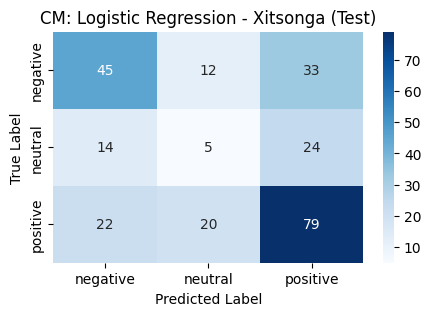


--- Training Naive Bayes for Xitsonga ---
Naive Bayes trained.

--- Evaluating Naive Bayes on Xitsonga Validation Set ---
Validation Accuracy: 0.6010
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.49      0.58        72
     neutral       0.00      0.00      0.00        35
    positive       0.56      0.91      0.69        96

    accuracy                           0.60       203
   macro avg       0.43      0.46      0.43       203
weighted avg       0.52      0.60      0.53       203


--- Evaluating Naive Bayes on Xitsonga Test Set ---
Test Accuracy: 0.5512
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.40      0.48        90
     neutral       0.00      0.00      0.00        43
    positive       0.54      0.86      0.66       121

    accuracy                           0.55       254
   macro avg       0.38      0.42      0.38       254
wei

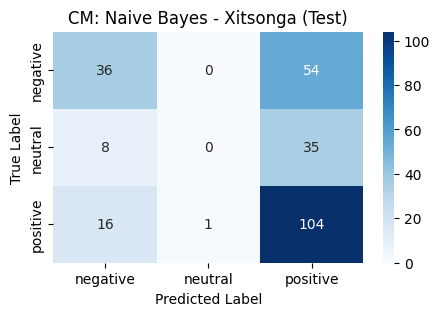


--- Training Random Forest for Xitsonga ---
Random Forest trained.

--- Evaluating Random Forest on Xitsonga Validation Set ---
Validation Accuracy: 0.5369
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.62      0.56      0.58        72
     neutral       0.08      0.06      0.07        35
    positive       0.59      0.70      0.64        96

    accuracy                           0.54       203
   macro avg       0.43      0.44      0.43       203
weighted avg       0.51      0.54      0.52       203


--- Evaluating Random Forest on Xitsonga Test Set ---
Test Accuracy: 0.5236
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.57      0.46      0.51        90
     neutral       0.24      0.21      0.22        43
    positive       0.58      0.69      0.63       121

    accuracy                           0.52       254
   macro avg       0.46      0.45      0.45      

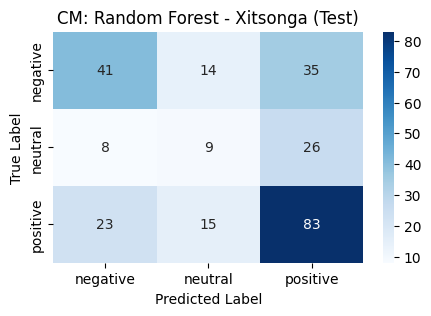


--- Xitsonga Baseline Modeling Complete ---


In [6]:
# @title E.1: Train and Evaluate Baseline Models for XITSONGA

# Dictionary to store all baseline results
all_baseline_results = {}

# Helper function to train one model and print its results
def train_evaluate_single_baseline(model_name, model_object,
                                   X_train_tfidf, y_train,
                                   X_val_tfidf, y_val,
                                   X_test_tfidf, y_test,
                                   language_name, numeric_to_label_map,
                                   results_storage):
    print(f"\n--- Training {model_name} for {language_name} ---")
    try:
        model_object.fit(X_train_tfidf, y_train)
        print(f"{model_name} trained.")

        current_model_metrics = {}

        # Evaluates on Validation Set
        if X_val_tfidf is not None and y_val is not None and not y_val.empty:
            print(f"\n--- Evaluating {model_name} on {language_name} Validation Set ---")
            y_pred_val = model_object.predict(X_val_tfidf)
            val_accuracy = accuracy_score(y_val, y_pred_val)
            unique_val_labels = sorted(y_val.unique())
            target_names_val = [numeric_to_label_map.get(l, str(l)) for l in unique_val_labels]
            val_report_str = classification_report(y_val, y_pred_val, labels=unique_val_labels, target_names=target_names_val, zero_division=0)
            val_report_dict = classification_report(y_val, y_pred_val, labels=unique_val_labels, output_dict=True, zero_division=0)

            print(f"Validation Accuracy: {val_accuracy:.4f}")
            print("Validation Classification Report:\n", val_report_str)
            current_model_metrics['val_accuracy'] = val_accuracy
            current_model_metrics['val_f1_macro'] = val_report_dict['macro avg']['f1-score']
            current_model_metrics['val_report_str'] = val_report_str
        else:
            print(f"Validation data not available for {language_name}, skipping validation evaluation for {model_name}.")


        # Evaluates on Test Set
        if X_test_tfidf is not None and y_test is not None and not y_test.empty:
            print(f"\n--- Evaluating {model_name} on {language_name} Test Set ---")
            y_pred_test = model_object.predict(X_test_tfidf)
            test_accuracy = accuracy_score(y_test, y_pred_test)
            unique_test_labels = sorted(y_test.unique())
            target_names_test = [numeric_to_label_map.get(l, str(l)) for l in unique_test_labels]
            test_report_str = classification_report(y_test, y_pred_test, labels=unique_test_labels, target_names=target_names_test, zero_division=0)
            test_report_dict = classification_report(y_test, y_pred_test, labels=unique_test_labels, output_dict=True, zero_division=0)

            print(f"Test Accuracy: {test_accuracy:.4f}")
            print("Test Classification Report:\n", test_report_str)
            current_model_metrics['test_accuracy'] = test_accuracy
            current_model_metrics['test_f1_macro'] = test_report_dict['macro avg']['f1-score']
            current_model_metrics['test_report_str'] = test_report_str

            # Confusion Matrix for Test Set
            cm_test = confusion_matrix(y_test, y_pred_test, labels=unique_test_labels)
            plt.figure(figsize=(5,3))
            sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                        xticklabels=target_names_test,
                        yticklabels=target_names_test)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'CM: {model_name} - {language_name} (Test)')
            plt.show()
        else:
            print(f"Test data not available for {language_name}, skipping test evaluation for {model_name}.")

        # Stores results for this model and language
        if language_name not in results_storage:
            results_storage[language_name] = {}
        results_storage[language_name][model_name] = current_model_metrics

    except Exception as e:
        print(f"!! ERROR with {model_name} for {language_name}: {e}")
        import traceback
        traceback.print_exc()
        if language_name not in results_storage:
            results_storage[language_name] = {}
        results_storage[language_name][model_name] = {'error': str(e)}


# --- Run for Xitsonga ---
if 'X_train_tfidf_xi' in locals() and X_train_tfidf_xi is not None:
    print("\n\n========== BASELINE MODELS FOR XITSONGA ==========")
    language_xi = "Xitsonga"

    # 1. Logistic Regression
    lr_model_xi = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)
    train_evaluate_single_baseline("Logistic Regression", lr_model_xi,
                                   X_train_tfidf_xi, y_train_xi,
                                   X_val_tfidf_xi, y_val_xi,
                                   X_test_tfidf_xi, y_test_xi,
                                   language_xi, numeric_to_sentiment_map_baseline,
                                   all_baseline_results)

    # 2. Naive Bayes
    nb_model_xi = MultinomialNB(alpha=1.0)
    train_evaluate_single_baseline("Naive Bayes", nb_model_xi,
                                   X_train_tfidf_xi, y_train_xi,
                                   X_val_tfidf_xi, y_val_xi,
                                   X_test_tfidf_xi, y_test_xi,
                                   language_xi, numeric_to_sentiment_map_baseline,
                                   all_baseline_results)

    # 3. Random Forest
    rf_model_xi = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    train_evaluate_single_baseline("Random Forest", rf_model_xi,
                                   X_train_tfidf_xi, y_train_xi,
                                   X_val_tfidf_xi, y_val_xi,
                                   X_test_tfidf_xi, y_test_xi,
                                   language_xi, numeric_to_sentiment_map_baseline,
                                   all_baseline_results)
else:
    print("Xitsonga TF-IDF features not available. Cannot train baseline models for Xitsonga.")

print("\n--- Xitsonga Baseline Modeling Complete ---")


In [7]:
# @title C.2: Load and Prepare SESOTHO Data for Baselines

print("--- Preparing Sesotho Data for Baselines ---")

sesotho_text_col = 'cleaned_text'
sesotho_label_col_numeric = 'label_numeric'
sesotho_label_map_to_standard = {-1: 0, 0: 1, 1: 2}

# Ensures the data loading and splitting function is defined
def process_language_data_for_baselines(file_path, text_column_name, label_column_name, label_mapping_dict, lang_name,
                                        original_labels_are_numeric_type, test_size=0.2, val_size=0.1):
    print(f"\nLoading and preparing {lang_name} data from: {file_path}")
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully read {file_path} as CSV.")
    except Exception as e_csv:
        print(f"Failed to read {file_path} as CSV: {e_csv}.")
        return [None]*6

    print(f"Original shape: {df.shape}, Columns: {df.columns.tolist()}")

    if text_column_name not in df.columns:
        print(f"ERROR: Text column '{text_column_name}' not found. Available: {df.columns.tolist()}")
        return [None]*6
    if label_column_name not in df.columns:
        print(f"ERROR: Label column '{label_column_name}' not found. Available: {df.columns.tolist()}")
        return [None]*6

    df_processed = df.copy()
    df_processed['text_for_model'] = df_processed[text_column_name].astype(str).fillna('')

    if original_labels_are_numeric_type:
        df_processed['original_label_values'] = df_processed[label_column_name]
    else:
        df_processed['original_label_values'] = df_processed[label_column_name].astype(str).str.lower().str.strip()

    print(f"Unique original labels in '{label_column_name}' for {lang_name}: {df_processed['original_label_values'].unique()}")
    df_processed['final_label_numeric'] = df_processed['original_label_values'].map(label_mapping_dict)

    # Drops rows where label mapping failed or text is effectively empty
    original_rows_count = len(df_processed)
    df_processed.dropna(subset=['final_label_numeric', 'text_for_model'], inplace=True)

    if df_processed['final_label_numeric'].isnull().any():
        unmapped_count = df_processed['final_label_numeric'].isnull().sum()
        print(f"Warning: {unmapped_count} labels in {lang_name} failed mapping and were dropped.")
        print(f"Original labels that failed: {df_processed[df_processed['final_label_numeric'].isnull()]['original_label_values'].unique()}")
    print(f"Rows after processing for {lang_name}: {len(df_processed)} (dropped {original_rows_count - len(df_processed)})")

    if len(df_processed) == 0:
        print(f"No data remaining for {lang_name}.")
        return [None]*6

    df_processed['final_label_numeric'] = df_processed['final_label_numeric'].astype(int)
    print(f"Value counts for standardized numeric labels (0,1,2) in {lang_name}:\n{df_processed['final_label_numeric'].value_counts(dropna=False)}")

    X_data = df_processed['text_for_model']
    y_data = df_processed['final_label_numeric']

    if len(X_data) < 20:
        print(f"Dataset for {lang_name} too small ({len(X_data)}). Using all for training.")
        return X_data, y_data, pd.Series(dtype='object'), pd.Series(dtype='int'), pd.Series(dtype='object'), pd.Series(dtype='int')

    try:
        y_counts = y_data.value_counts()
        can_stratify_test = y_data.nunique() > 1 and all(y_counts * test_size >= 1) and all(y_counts * (1-test_size) >= 1)

        X_train_val, X_test_lang, y_train_val, y_test_lang = train_test_split(
            X_data, y_data, test_size=test_size, random_state=42, stratify=y_data if can_stratify_test else None
        )
        if not can_stratify_test: print(f"Warning: Stratification for test split of {lang_name} might not be ideal due to class sizes.")

        relative_val_size = val_size / (1.0 - test_size)
        y_train_val_counts = y_train_val.value_counts()
        can_stratify_val = y_train_val.nunique() > 1 and all(y_train_val_counts * relative_val_size >= 1) and all(y_train_val_counts * (1-relative_val_size) >=1)

        if len(X_train_val) < 2:
            X_train_lang, y_train_lang, X_val_lang, y_val_lang = X_train_val, y_train_val, pd.Series(dtype='object'), pd.Series(dtype='int')
        else:
            X_train_lang, X_val_lang, y_train_lang, y_val_lang = train_test_split(
                X_train_val, y_train_val, test_size=relative_val_size, random_state=42, stratify=y_train_val if can_stratify_val else None
            )
            if not can_stratify_val: print(f"Warning: Stratification for validation split of {lang_name} might not be ideal.")

    except ValueError as e:
        print(f"ValueError during split for {lang_name}: {e}. Using all data as training.")
        return X_data, y_data, pd.Series(dtype='object'), pd.Series(dtype='int'), pd.Series(dtype='object'), pd.Series(dtype='int')

    print(f"Shapes for {lang_name}: Train ({len(X_train_lang)}), Val ({len(X_val_lang)}), Test ({len(X_test_lang)})")
    return X_train_lang, y_train_lang, X_val_lang, y_val_lang, X_test_lang, y_test_lang


# --- Load and Prepare Sesotho Data ---
X_train_st, y_train_st, X_val_st, y_val_st, X_test_st, y_test_st = [None]*6
if os.path.exists(sesotho_new_cleaned_file):
    X_train_st, y_train_st, X_val_st, y_val_st, X_test_st, y_test_st = process_language_data_for_baselines(
        file_path=sesotho_new_cleaned_file,
        text_column_name=sesotho_text_col,
        label_column_name=sesotho_label_col_numeric,
        label_mapping_dict=sesotho_label_map_to_standard,
        lang_name="Sesotho",
        original_labels_are_numeric_type=True
    )
    if X_train_st is not None and not X_train_st.empty:
        print("\nSesotho data successfully prepared for baseline modeling.")
    else:
        print(f"Sesotho data preparation failed.")
else:
    print(f"Sesotho cleaned CSV file not found at: {sesotho_new_cleaned_file}")

--- Preparing Sesotho Data for Baselines ---

Loading and preparing Sesotho data from: /content/drive/MyDrive/NLPS1/Cleaned/sesotho_cleaned.csv
Successfully read /content/drive/MyDrive/NLPS1/Cleaned/sesotho_cleaned.csv as CSV.
Original shape: (2208, 5), Columns: ['text', 'label_numeric', 'label', 'cleaned_text', 'tokens']
Unique original labels in 'label_numeric' for Sesotho: [-1  0  1]
Rows after processing for Sesotho: 2208 (dropped 0)
Value counts for standardized numeric labels (0,1,2) in Sesotho:
final_label_numeric
0    1552
2     550
1     106
Name: count, dtype: int64
Shapes for Sesotho: Train (1545), Val (221), Test (442)

Sesotho data successfully prepared for baseline modeling.


In [8]:
# @title D.2 : TF-IDF Feature Extraction for SESOTHO

from sklearn.feature_extraction.text import TfidfVectorizer

if 'X_train_st' in locals() and X_train_st is not None and not X_train_st.empty:
    print("\n--- TF-IDF Vectorization for Sesotho ---")
    tfidf_vectorizer_st_new = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words=None)

    print("Fitting TF-IDF on Sesotho training text...")
    X_train_tfidf_st_new = tfidf_vectorizer_st_new.fit_transform(X_train_st)
    print(f"Shape of TF-IDF for Sesotho training: {X_train_tfidf_st_new.shape}")

    X_val_tfidf_st_new = tfidf_vectorizer_st_new.transform(X_val_st) if X_val_st is not None and not X_val_st.empty else None
    X_test_tfidf_st_new = tfidf_vectorizer_st_new.transform(X_test_st) if X_test_st is not None and not X_test_st.empty else None
    if X_val_tfidf_st_new is not None: print(f"Shape of TF-IDF for Sesotho validation: {X_val_tfidf_st_new.shape}")
    if X_test_tfidf_st_new is not None: print(f"Shape of TF-IDF for Sesotho test: {X_test_tfidf_st_new.shape}")
else:
    print("Sesotho training data (X_train_st) not available. Cannot perform TF-IDF.")
    X_train_tfidf_st_new, X_val_tfidf_st_new, X_test_tfidf_st_new = [None]*3


--- TF-IDF Vectorization for Sesotho ---
Fitting TF-IDF on Sesotho training text...
Shape of TF-IDF for Sesotho training: (1545, 2017)
Shape of TF-IDF for Sesotho validation: (221, 2017)
Shape of TF-IDF for Sesotho test: (442, 2017)




========== BASELINE MODELS FOR SESOTHO ==========

--- Training Logistic Regression for Sesotho (New) ---
Logistic Regression trained.

--- Evaluating Logistic Regression on Sesotho (New) Validation Set ---
Validation Accuracy: 0.8054
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.91      0.87       155
     neutral       0.83      0.45      0.59        11
    positive       0.70      0.58      0.63        55

    accuracy                           0.81       221
   macro avg       0.79      0.65      0.70       221
weighted avg       0.80      0.81      0.80       221


--- Evaluating Logistic Regression on Sesotho (New) Test Set ---
Test Accuracy: 0.7919
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.91      0.87       311
     neutral       0.60      0.29      0.39        21
    positive       0.67      0.56      0.61       110

    accuracy

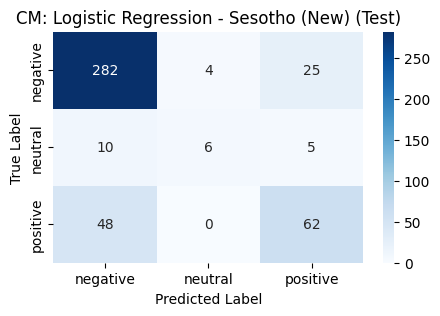


--- Training Naive Bayes for Sesotho (New) ---
Naive Bayes trained.

--- Evaluating Naive Bayes on Sesotho (New) Validation Set ---
Validation Accuracy: 0.7828
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.99      0.87       155
     neutral       1.00      0.09      0.17        11
    positive       0.86      0.35      0.49        55

    accuracy                           0.78       221
   macro avg       0.88      0.47      0.51       221
weighted avg       0.81      0.78      0.74       221


--- Evaluating Naive Bayes on Sesotho (New) Test Set ---
Test Accuracy: 0.7647
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.75      1.00      0.86       311
     neutral       1.00      0.10      0.17        21
    positive       0.90      0.24      0.37       110

    accuracy                           0.76       442
   macro avg       0.88      0.44      0.4

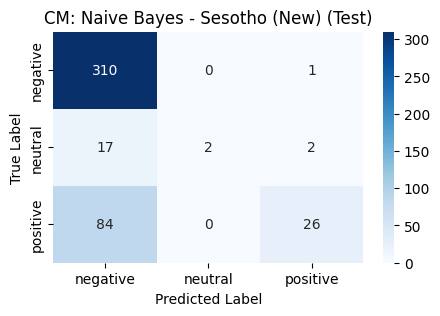


--- Training Random Forest for Sesotho (New) ---
Random Forest trained.

--- Evaluating Random Forest on Sesotho (New) Validation Set ---
Validation Accuracy: 0.7602
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.94      0.85       155
     neutral       1.00      0.27      0.43        11
    positive       0.67      0.36      0.47        55

    accuracy                           0.76       221
   macro avg       0.81      0.52      0.58       221
weighted avg       0.76      0.76      0.73       221


--- Evaluating Random Forest on Sesotho (New) Test Set ---
Test Accuracy: 0.7557
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.95      0.85       311
     neutral       1.00      0.19      0.32        21
    positive       0.65      0.32      0.43       110

    accuracy                           0.76       442
   macro avg       0.81      0.49 

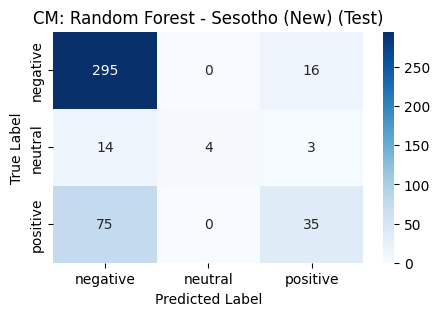


--- Sesotho Baseline Modeling Complete ---


In [9]:
# @title E.2 : Train and Evaluate Baseline Models for SESOTHO

# Ensure 'train_evaluate_single_baseline' function is defined
# Ensure 'all_baseline_results' dictionary is initialized
# Ensure 'numeric_to_sentiment_map_baseline' is defined {0:'negative', 1:'neutral', 2:'positive'}

if 'all_baseline_results' not in locals(): all_baseline_results = {}
if 'numeric_to_sentiment_map_baseline' not in locals(): numeric_to_sentiment_map_baseline = {0:"negative", 1:"neutral", 2:"positive"}


if 'X_train_tfidf_st_new' in locals() and X_train_tfidf_st_new is not None:
    print("\n\n========== BASELINE MODELS FOR SESOTHO ==========")
    lang_st_new = "Sesotho (New)"

    if 'y_train_st' not in locals() or y_train_st is None or y_train_st.empty:
        print(f"Skipping Sesotho baselines as y_train_st is missing or empty.")
    else:
        lr_model_st_new = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)
        train_evaluate_single_baseline("Logistic Regression", lr_model_st_new,
                                       X_train_tfidf_st_new, y_train_st,
                                       X_val_tfidf_st_new, y_val_st if 'y_val_st' in locals() and y_val_st is not None else None,
                                       X_test_tfidf_st_new, y_test_st if 'y_test_st' in locals() and y_test_st is not None else None,
                                       lang_st_new, numeric_to_sentiment_map_baseline,
                                       all_baseline_results)

        nb_model_st_new = MultinomialNB(alpha=1.0)
        train_evaluate_single_baseline("Naive Bayes", nb_model_st_new,
                                       X_train_tfidf_st_new, y_train_st,
                                       X_val_tfidf_st_new, y_val_st if 'y_val_st' in locals() and y_val_st is not None else None,
                                       X_test_tfidf_st_new, y_test_st if 'y_test_st' in locals() and y_test_st is not None else None,
                                       lang_st_new, numeric_to_sentiment_map_baseline,
                                       all_baseline_results)

        rf_model_st_new = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
        train_evaluate_single_baseline("Random Forest", rf_model_st_new,
                                       X_train_tfidf_st_new, y_train_st,
                                       X_val_tfidf_st_new, y_val_st if 'y_val_st' in locals() and y_val_st is not None else None,
                                       X_test_tfidf_st_new, y_test_st if 'y_test_st' in locals() and y_test_st is not None else None,
                                       lang_st_new, numeric_to_sentiment_map_baseline,
                                       all_baseline_results)
else:
    print("Sesotho TF-IDF features not available. Cannot train baselines.")

print("\n--- Sesotho Baseline Modeling Complete ---")

In [10]:
# @title C.3 : Load and Prepare SETSWANA Data for Baselines

print("--- Preparing Setswana Data for Baselines ---")

# --- Column Names for Setswana file ---
setswana_text_col = 'cleaned_sentence'
setswana_label_col_text = 'Final_Label'
setswana_label_map_to_standard = {'negative': 0, 'neutral': 1, 'positive': 2}


# --- Load and Prepare Setswana Data ---
X_train_tn, y_train_tn, X_val_tn, y_val_tn, X_test_tn, y_test_tn = [None]*6
if 'process_language_data_for_baselines' not in globals():
    print("ERROR: `process_language_data_for_baselines` function not defined. Please run Cell C.2 (NEW) first.")
elif not os.path.exists(setswana_new_cleaned_file):
    print(f"Setswana cleaned CSV file not found at: {setswana_new_cleaned_file}")
else:
    X_train_tn, y_train_tn, X_val_tn, y_val_tn, X_test_tn, y_test_tn = process_language_data_for_baselines(
        file_path=setswana_new_cleaned_file,
        text_column_name=setswana_text_col,
        label_column_name=setswana_label_col_text,
        label_mapping_dict=setswana_label_map_to_standard,
        lang_name="Setswana",
        original_labels_are_numeric_type=False
    )
    if X_train_tn is not None and not X_train_tn.empty:
        print("\nSetswana data successfully prepared for baseline modeling.")
        print("Sample of prepared training data (Setswana):")
        print("Text (first 5):", X_train_tn.head().tolist())
        print("Labels (first 5 - should be 0,1,or 2):", y_train_tn.head().tolist())
    else:
        print(f"Setswana data preparation failed.")

--- Preparing Setswana Data for Baselines ---

Loading and preparing Setswana data from: /content/drive/MyDrive/NLPS1/Cleaned/setswana_cleaned.csv
Successfully read /content/drive/MyDrive/NLPS1/Cleaned/setswana_cleaned.csv as CSV.
Original shape: (2407, 5), Columns: ['sentence', 'Final_Label', 'predict_name', 'cleaned_sentence', 'tokens']
Unique original labels in 'Final_Label' for Setswana: ['positive' 'negative' 'neutral']
Rows after processing for Setswana: 2407 (dropped 0)
Value counts for standardized numeric labels (0,1,2) in Setswana:
final_label_numeric
0    1081
2     672
1     654
Name: count, dtype: int64
Shapes for Setswana: Train (1684), Val (241), Test (482)

Setswana data successfully prepared for baseline modeling.
Sample of prepared training data (Setswana):
Text (first 5): ['ooh tswa kgakala aa le well thembi waitsi ng', 'nnyaa ese ka lepe hela nkgonne', 're tswa kgakala', 'i like men gore o tla a ntse jang ke tlaa mo rata', 'that tall pedi gent who hates bathing show

In [11]:
# @title D.3 : TF-IDF Feature Extraction for SETSWANA


if 'X_train_tn' in locals() and X_train_tn is not None and not X_train_tn.empty:
    print("\n--- TF-IDF Vectorization for Setswana ---")
    tfidf_vectorizer_tn_new = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words=None)

    print("Fitting TF-IDF on Setswana training text...")
    X_train_tfidf_tn_new = tfidf_vectorizer_tn_new.fit_transform(X_train_tn)
    print(f"Shape of TF-IDF for Setswana training: {X_train_tfidf_tn_new.shape}")

    X_val_tfidf_tn_new = tfidf_vectorizer_tn_new.transform(X_val_tn) if X_val_tn is not None and not X_val_tn.empty else None
    X_test_tfidf_tn_new = tfidf_vectorizer_tn_new.transform(X_test_tn) if X_test_tn is not None and not X_test_tn.empty else None

    if X_val_tfidf_tn_new is not None: print(f"Shape of TF-IDF for Setswana validation: {X_val_tfidf_tn_new.shape}")
    else: print("Setswana validation data is empty or TF-IDF failed.")

    if X_test_tfidf_tn_new is not None: print(f"Shape of TF-IDF for Setswana test: {X_test_tfidf_tn_new.shape}")
    else: print("Setswana test data is empty or TF-IDF failed.")

else:
    print("Setswana training data (X_train_tn) not available. Cannot perform TF-IDF.")
    X_train_tfidf_tn_new, X_val_tfidf_tn_new, X_test_tfidf_tn_new = [None]*3


--- TF-IDF Vectorization for Setswana ---
Fitting TF-IDF on Setswana training text...
Shape of TF-IDF for Setswana training: (1684, 2577)
Shape of TF-IDF for Setswana validation: (241, 2577)
Shape of TF-IDF for Setswana test: (482, 2577)




========== BASELINE MODELS FOR SETSWANA ==========

--- Training Logistic Regression for Setswana (New) ---
Logistic Regression trained.

--- Evaluating Logistic Regression on Setswana (New) Validation Set ---
Validation Accuracy: 0.4938
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.55      0.67      0.60       108
     neutral       0.50      0.50      0.50        66
    positive       0.33      0.21      0.25        67

    accuracy                           0.49       241
   macro avg       0.46      0.46      0.45       241
weighted avg       0.47      0.49      0.48       241


--- Evaluating Logistic Regression on Setswana (New) Test Set ---
Test Accuracy: 0.5373
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.58      0.75      0.65       216
     neutral       0.55      0.46      0.50       131
    positive       0.40      0.28      0.33       135

    accu

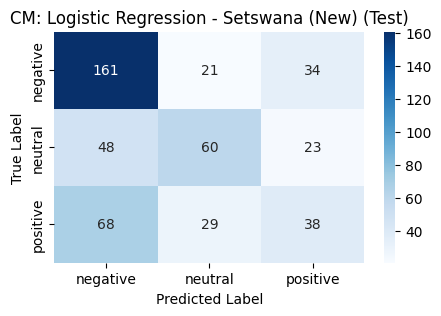


--- Training Naive Bayes for Setswana (New) ---
Naive Bayes trained.

--- Evaluating Naive Bayes on Setswana (New) Validation Set ---
Validation Accuracy: 0.5062
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.50      0.94      0.65       108
     neutral       0.67      0.27      0.39        66
    positive       0.27      0.04      0.08        67

    accuracy                           0.51       241
   macro avg       0.48      0.42      0.37       241
weighted avg       0.48      0.51      0.42       241


--- Evaluating Naive Bayes on Setswana (New) Test Set ---
Test Accuracy: 0.5104
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.50      0.94      0.65       216
     neutral       0.63      0.20      0.30       131
    positive       0.53      0.12      0.19       135

    accuracy                           0.51       482
   macro avg       0.55      0.42      

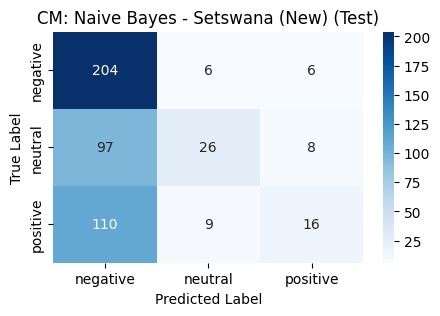


--- Training Random Forest for Setswana (New) ---
Random Forest trained.

--- Evaluating Random Forest on Setswana (New) Validation Set ---
Validation Accuracy: 0.5021
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.54      0.64      0.59       108
     neutral       0.49      0.62      0.55        66
    positive       0.37      0.16      0.23        67

    accuracy                           0.50       241
   macro avg       0.47      0.47      0.45       241
weighted avg       0.48      0.50      0.48       241


--- Evaluating Random Forest on Setswana (New) Test Set ---
Test Accuracy: 0.5249
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.58      0.71      0.64       216
     neutral       0.50      0.59      0.54       131
    positive       0.34      0.17      0.23       135

    accuracy                           0.52       482
   macro avg       0.48      0.

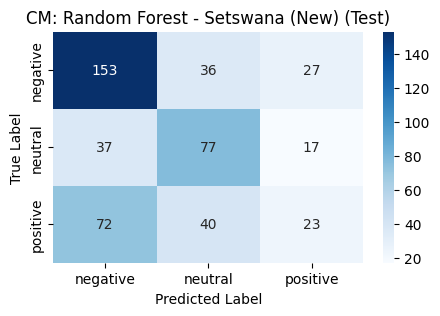


--- Setswana Baseline Modeling Complete ---


In [12]:
# @title E.3 : Train and Evaluate Baseline Models for SETSWANA

# Ensure 'train_evaluate_single_baseline' function is defined
# Ensure 'all_baseline_results' dictionary is initialized
# Ensure 'numeric_to_sentiment_map_baseline' is defined {0:'negative', 1:'neutral', 2:'positive'}

if 'all_baseline_results' not in locals(): all_baseline_results = {}
if 'numeric_to_sentiment_map_baseline' not in locals(): numeric_to_sentiment_map_baseline = {0:"negative", 1:"neutral", 2:"positive"}
if 'train_evaluate_single_baseline' not in globals():
    print("ERROR: `train_evaluate_single_baseline` function not defined. Please run Cell E.1 first.")
else:
    if 'X_train_tfidf_tn_new' in locals() and X_train_tfidf_tn_new is not None:
        print("\n\n========== BASELINE MODELS FOR SETSWANA ==========")
        lang_tn_new = "Setswana (New)"

        if 'y_train_tn' not in locals() or y_train_tn is None or y_train_tn.empty:
            print(f"Skipping Setswana baselines as y_train_tn is missing or empty.")
        else:
            lr_model_tn_new = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)
            train_evaluate_single_baseline("Logistic Regression", lr_model_tn_new,
                                           X_train_tfidf_tn_new, y_train_tn,
                                           X_val_tfidf_tn_new, y_val_tn if 'y_val_tn' in locals() and y_val_tn is not None else None,
                                           X_test_tfidf_tn_new, y_test_tn if 'y_test_tn' in locals() and y_test_tn is not None else None,
                                           lang_tn_new, numeric_to_sentiment_map_baseline,
                                           all_baseline_results)

            nb_model_tn_new = MultinomialNB(alpha=1.0)
            train_evaluate_single_baseline("Naive Bayes", nb_model_tn_new,
                                           X_train_tfidf_tn_new, y_train_tn,
                                           X_val_tfidf_tn_new, y_val_tn if 'y_val_tn' in locals() and y_val_tn is not None else None,
                                           X_test_tfidf_tn_new, y_test_tn if 'y_test_tn' in locals() and y_test_tn is not None else None,
                                           lang_tn_new, numeric_to_sentiment_map_baseline,
                                           all_baseline_results)

            rf_model_tn_new = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
            train_evaluate_single_baseline("Random Forest", rf_model_tn_new,
                                           X_train_tfidf_tn_new, y_train_tn,
                                           X_val_tfidf_tn_new, y_val_tn if 'y_val_tn' in locals() and y_val_tn is not None else None,
                                           X_test_tfidf_tn_new, y_test_tn if 'y_test_tn' in locals() and y_test_tn is not None else None,
                                           lang_tn_new, numeric_to_sentiment_map_baseline,
                                           all_baseline_results)
    else:
        print("Setswana TF-IDF features not available. Cannot train baselines.")

print("\n--- Setswana Baseline Modeling Complete ---")

In [13]:
# @title F: Display All Baseline Results Summary

print("\n\n--- Summary of All Baseline Model Performances (Test F1 Macro & Accuracy) ---")
# Ensures all_baseline_results is defined
if 'all_baseline_results' not in locals() or not all_baseline_results:
    print("No baseline results to display. Please run E.1, E.2 , and E.3 .")
else:
    for language, lang_results in all_baseline_results.items():
        print(f"\n--- {language} ---")
        if not lang_results:
            print("  No results recorded.")
            continue
        sorted_model_names = sorted(lang_results.keys())

        for model_name in sorted_model_names:
            model_metrics = lang_results[model_name]
            print(f"  Model: {model_name}")
            if 'error' in model_metrics:
                print(f"    Error: {model_metrics['error']}")
            elif 'test_f1_macro' in model_metrics:
                test_f1 = model_metrics['test_f1_macro']
                test_acc = model_metrics.get('test_accuracy', 'N/A')
                print(f"    Test F1 Macro = {test_f1:.4f} | Test Accuracy = {test_acc if isinstance(test_acc, str) else f'{test_acc:.4f}'}")
                val_f1 = model_metrics.get('val_f1_macro', 'N/A')
                val_acc = model_metrics.get('val_accuracy', 'N/A')
                if val_f1 != 'N/A':
                     print(f"    Val F1 Macro  = {val_f1:.4f} | Val Accuracy  = {val_acc if isinstance(val_acc, str) else f'{val_acc:.4f}'}")
            elif 'val_f1_macro' in model_metrics:
                val_f1 = model_metrics.get('val_f1_macro', 'N/A')
                val_acc = model_metrics.get('val_accuracy', 'N/A')
                print(f"    Val F1 Macro  = {val_f1:.4f} | Val Accuracy  = {val_acc if isinstance(val_acc, str) else f'{val_acc:.4f}'} (Test results N/A)")
            else:
                print(f"    Metrics not available.")



--- Summary of All Baseline Model Performances (Test F1 Macro & Accuracy) ---

--- Xitsonga ---
  Model: Logistic Regression
    Test F1 Macro = 0.4220 | Test Accuracy = 0.5079
    Val F1 Macro  = 0.4627 | Val Accuracy  = 0.5567
  Model: Naive Bayes
    Test F1 Macro = 0.3808 | Test Accuracy = 0.5512
    Val F1 Macro  = 0.4255 | Val Accuracy  = 0.6010
  Model: Random Forest
    Test F1 Macro = 0.4516 | Test Accuracy = 0.5236
    Val F1 Macro  = 0.4299 | Val Accuracy  = 0.5369

--- Sesotho (New) ---
  Model: Logistic Regression
    Test F1 Macro = 0.6224 | Test Accuracy = 0.7919
    Val F1 Macro  = 0.6974 | Val Accuracy  = 0.8054
  Model: Naive Bayes
    Test F1 Macro = 0.4689 | Test Accuracy = 0.7647
    Val F1 Macro  = 0.5090 | Val Accuracy  = 0.7828
  Model: Random Forest
    Test F1 Macro = 0.5319 | Test Accuracy = 0.7557
    Val F1 Macro  = 0.5815 | Val Accuracy  = 0.7602

--- Setswana (New) ---
  Model: Logistic Regression
    Test F1 Macro = 0.4938 | Test Accuracy = 0.5373
    

In [14]:
# @title I.S1: Prepare SESOTHO Data for Hugging Face Datasets (for AfriBERTa)

from datasets import Dataset, DatasetDict, ClassLabel

# --- Ensures 'all_advanced_results' dictionary exists ---
if 'all_advanced_results' not in locals():
    all_advanced_results = {}
    print("`all_advanced_results` dictionary (re)initialized.")

# --- Sets current language for this run ---
CURRENT_LANGUAGE_NAME = "Sesotho" # <<<< Set for Sesotho
print(f"===== Preparing data for: {CURRENT_LANGUAGE_NAME} (for AfriBERTa) =====")


if ('X_train_st' in locals() and X_train_st is not None and not X_train_st.empty and
    'y_train_st' in locals() and y_train_st is not None and not y_train_st.empty):

    print(f"--- Preparing {CURRENT_LANGUAGE_NAME} Data for Hugging Face ---")
    print(f"Using Sesotho training data of size: {len(X_train_st)}")

    df_hf_train_current = pd.DataFrame({'text': X_train_st, 'label': y_train_st})
    df_hf_val_current = pd.DataFrame({'text': X_val_st, 'label': y_val_st})
    df_hf_test_current = pd.DataFrame({'text': X_test_st, 'label': y_test_st})

    hf_train_dataset_current = Dataset.from_pandas(df_hf_train_current)
    hf_val_dataset_current = Dataset.from_pandas(df_hf_val_current) if not df_hf_val_current.empty else Dataset.from_dict({'text':[], 'label':[]})
    hf_test_dataset_current = Dataset.from_pandas(df_hf_test_current) if not df_hf_test_current.empty else Dataset.from_dict({'text':[], 'label':[]})

    raw_datasets_current_lang = DatasetDict({
        'train': hf_train_dataset_current,
        'validation': hf_val_dataset_current,
        'test': hf_test_dataset_current
    })
    for split in raw_datasets_current_lang:
        if '__index_level_0__' in raw_datasets_current_lang[split].column_names:
            raw_datasets_current_lang[split] = raw_datasets_current_lang[split].remove_columns(['__index_level_0__'])

    print(f"\n{CURRENT_LANGUAGE_NAME} data converted to Hugging Face DatasetDict:")
    print(raw_datasets_current_lang)

    # Uses numeric_to_sentiment_map_baseline for consistency if defined
    if 'numeric_to_sentiment_map_baseline' in locals():
        id2label_current_lang = numeric_to_sentiment_map_baseline
        label2id_current_lang = {v: k for k,v in id2label_current_lang.items()}
        num_labels_current_lang = len(id2label_current_lang)
        print(f"\nLabel mapping for {CURRENT_LANGUAGE_NAME} HF: id2label={id2label_current_lang}, num_labels={num_labels_current_lang}")
    else:
        print("Warning: `numeric_to_sentiment_map_baseline` not found. Defining default.")
        id2label_current_lang = {0: 'negative', 1: 'neutral', 2: 'positive'}
        label2id_current_lang = {v: k for k,v in id2label_current_lang.items()}
        num_labels_current_lang = 3

    print(f"\nSample from {CURRENT_LANGUAGE_NAME} training dataset (Hugging Face format):")
    if len(raw_datasets_current_lang['train']) > 0:
        print(raw_datasets_current_lang['train'][0])
    else:
        print(f"{CURRENT_LANGUAGE_NAME} training dataset is empty.")
else:
    print(f"NEW {CURRENT_LANGUAGE_NAME} data not available or is empty.")

`all_advanced_results` dictionary (re)initialized.
===== Preparing data for: Sesotho (for AfriBERTa) =====
--- Preparing Sesotho Data for Hugging Face ---
Using Sesotho training data of size: 1545

Sesotho data converted to Hugging Face DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 221
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 442
    })
})

Label mapping for Sesotho HF: id2label={0: 'negative', 1: 'neutral', 2: 'positive'}, num_labels=3

Sample from Sesotho training dataset (Hugging Face format):
{'text': 'monna o qosoa ka koloi e se nang linomoro', 'label': 0}


In [15]:
# @title J.S2.1: Define AfriBERTa Checkpoint and Tokenizer (for SESOTHO Data)

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- Settings for this specific run: SESOTHO Data, AfriBERTa ---


if 'CURRENT_LANGUAGE_NAME' not in locals() or CURRENT_LANGUAGE_NAME != "Sesotho":
    print("ERROR: CURRENT_LANGUAGE_NAME is not 'Sesotho'. Please ensure Cell I.S1 was run correctly.")
    raise NameError("CURRENT_LANGUAGE_NAME not correctly set for NEW Sesotho run.")
else:
    MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO = "castorini/afriberta_base"

    print(f"--- Advanced Model: Full Fine-tuning for {CURRENT_LANGUAGE_NAME} using {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} ---")

    if 'device' not in locals():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device set to: {device}")
    else:
        print(f"Using existing device: {device}")

    try:
        tokenizer_afriberta_new_sesotho = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO)
        print(f"\nTokenizer for {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} loaded successfully (for Sesotho).")
    except Exception as e:
        print(f"Error loading tokenizer for {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO}: {e}")
        tokenizer_afriberta_new_sesotho = None

--- Advanced Model: Full Fine-tuning for Sesotho using castorini/afriberta_base ---
Device set to: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]


Tokenizer for castorini/afriberta_base loaded successfully (for Sesotho).


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [16]:
# @title J.S2.2: Tokenize SESOTHO Datasets (for AfriBERTa)

from transformers import DataCollatorWithPadding

if 'tokenizer_afriberta_new_sesotho' in locals() and tokenizer_afriberta_new_sesotho and \
   'raw_datasets_current_lang' in locals() and raw_datasets_current_lang and \
   CURRENT_LANGUAGE_NAME == "Sesotho":

    def tokenize_function_afriberta_new_sesotho_ft(examples):
        return tokenizer_afriberta_new_sesotho(examples["text"], truncation=True, padding=False, max_length=512)

    print(f"Tokenizing {CURRENT_LANGUAGE_NAME} datasets with {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} tokenizer...")
    try:
        tokenized_datasets_afriberta_new_sesotho = raw_datasets_current_lang.map(
            tokenize_function_afriberta_new_sesotho_ft,
            batched=True,
            remove_columns=["text"]
        )
        print(f"\nTokenization complete for {CURRENT_LANGUAGE_NAME}  using {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO}.")
        print(tokenized_datasets_afriberta_new_sesotho)

        data_collator_afriberta_new_sesotho = DataCollatorWithPadding(tokenizer=tokenizer_afriberta_new_sesotho)
        print(f"\nData collator initialized for {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} Sesotho.")

    except Exception as e:
        print(f"Error during dataset tokenization for {CURRENT_LANGUAGE_NAME}: {e}")
        tokenized_datasets_afriberta_new_sesotho = None
        data_collator_afriberta_new_sesotho = None
else:
    print("Prerequisites for tokenizing NEW Sesotho AfriBERTa data not met.")

Tokenizing Sesotho datasets with castorini/afriberta_base tokenizer...


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Map:   0%|          | 0/442 [00:00<?, ? examples/s]


Tokenization complete for Sesotho  using castorini/afriberta_base.
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 221
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 442
    })
})

Data collator initialized for castorini/afriberta_base Sesotho.


In [17]:
# @title J.S2.3: Define AfriBERTa Model (Full Fine-tuning for SESOTHO Data)

if 'tokenized_datasets_afriberta_new_sesotho' in locals() and tokenized_datasets_afriberta_new_sesotho and \
   'id2label_current_lang' in locals() and 'label2id_current_lang' in locals() and 'num_labels_current_lang' in locals() and \
   CURRENT_LANGUAGE_NAME == "Sesotho":

    print(f"Number of labels for {CURRENT_LANGUAGE_NAME} : {num_labels_current_lang}")

    try:
        model_afriberta_new_sesotho_ft = AutoModelForSequenceClassification.from_pretrained(
            MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO,
            num_labels=num_labels_current_lang,
            id2label=id2label_current_lang,
            label2id=label2id_current_lang
        )
        model_afriberta_new_sesotho_ft.to(device)
        print(f"\nModel {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} loaded for Full FT ({CURRENT_LANGUAGE_NAME} - Data) and moved to {device}.")
    except Exception as e:
        print(f"Error loading model {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} for {CURRENT_LANGUAGE_NAME} : {e}")
        model_afriberta_new_sesotho_ft = None
else:
    print("Required variables for Sesotho AfriBERTa Full FT model definition not found or language mismatch.")

Number of labels for Sesotho : 3


pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]


Model castorini/afriberta_base loaded for Full FT (Sesotho - Data) and moved to cuda.


In [18]:
# @title J.S2.4: Training Arguments for AfriBERTa Full Fine-tuning (SESOTHO Data)

from transformers import TrainingArguments
import os

if 'model_afriberta_new_sesotho_ft' in locals() and model_afriberta_new_sesotho_ft and \
    CURRENT_LANGUAGE_NAME == "Sesotho":

    ft_output_dir_afriberta_new_sesotho = f"/content/drive/MyDrive/NLPS1/models/{CURRENT_LANGUAGE_NAME}_NewData/{MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO.split('/')[-1]}-full"
    print(f"Full FT model for {CURRENT_LANGUAGE_NAME} AfriBERTa will be saved to: {ft_output_dir_afriberta_new_sesotho}")
    os.makedirs(ft_output_dir_afriberta_new_sesotho, exist_ok=True)
    os.makedirs(f"{ft_output_dir_afriberta_new_sesotho}/logs", exist_ok=True)

    training_args_afriberta_new_sesotho_ft = TrainingArguments(
        output_dir=ft_output_dir_afriberta_new_sesotho,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=50,
        weight_decay=0.01,
        logging_dir=f"{ft_output_dir_afriberta_new_sesotho}/logs",
        logging_steps=40,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="tensorboard",
    )

    if torch.cuda.is_available() and torch.cuda.get_device_capability(device)[0] >= 7:
        training_args_afriberta_new_sesotho_ft.fp16 = True
        print("fp16 ENABLED for Sesotho AfriBERTa full fine-tuning.")
    else:
        training_args_afriberta_new_sesotho_ft.fp16 = False
        print("fp16 DISABLED for Sesotho AfriBERTa full fine-tuning.")

    print(f"\nTrainingArguments defined for {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} full fine-tuning on {CURRENT_LANGUAGE_NAME} .")
else:
    print(f"Model for Sesotho AfriBERTa Full FT not loaded or language mismatch.")

Full FT model for Sesotho AfriBERTa will be saved to: /content/drive/MyDrive/NLPS1/models/Sesotho_NewData/afriberta_base-full
fp16 ENABLED for Sesotho AfriBERTa full fine-tuning.

TrainingArguments defined for castorini/afriberta_base full fine-tuning on Sesotho .


In [19]:
# Install the 'evaluate' library
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00


In [20]:
# @title J.S2.5: Define Metrics Computation Function

import numpy as np
from evaluate import load as load_metric

if 'compute_metrics_adv' not in globals():
    print("Defining `compute_metrics_adv` function.")
    if 'accuracy_metric' not in globals():
        accuracy_metric = load_metric("accuracy")
        f1_metric = load_metric("f1")
        precision_metric = load_metric("precision")
        recall_metric = load_metric("recall")
        print("Metrics from `evaluate` library (re)loaded.")

    def compute_metrics_adv(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
        f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
        precision = precision_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)["precision"]
        recall = recall_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)["recall"]
        return { "accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall }
else:
    print("`compute_metrics_adv` function already defined.")

print("`compute_metrics_adv` function ready for Sesotho AfriBERTa.")

Defining `compute_metrics_adv` function.


Metrics from `evaluate` library (re)loaded.
`compute_metrics_adv` function ready for Sesotho AfriBERTa.


In [21]:
# @title J.S2.6: Initialize and Run Trainer (AfriBERTa Full Fine-tuning on SESOTHO Data)

from transformers import Trainer

if 'model_afriberta_new_sesotho_ft' in locals() and model_afriberta_new_sesotho_ft and \
   'tokenized_datasets_afriberta_new_sesotho' in locals() and tokenized_datasets_afriberta_new_sesotho and \
   'data_collator_afriberta_new_sesotho' in locals() and data_collator_afriberta_new_sesotho and \
   'training_args_afriberta_new_sesotho_ft' in locals() and 'compute_metrics_adv' in locals() and \
   CURRENT_LANGUAGE_NAME == "Sesotho":

    trainer_afriberta_new_sesotho_ft = Trainer(
        model=model_afriberta_new_sesotho_ft,
        args=training_args_afriberta_new_sesotho_ft,
        train_dataset=tokenized_datasets_afriberta_new_sesotho["train"],
        eval_dataset=tokenized_datasets_afriberta_new_sesotho["validation"],
        tokenizer=tokenizer_afriberta_new_sesotho,
        data_collator=data_collator_afriberta_new_sesotho,
        compute_metrics=compute_metrics_adv,
    )

    print(f"\nTrainer for {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} Full FT on {CURRENT_LANGUAGE_NAME} initialized. Starting training...")
    try:
        train_result_afriberta_new_sesotho_ft = trainer_afriberta_new_sesotho_ft.train()
        print("\nTraining finished.")
        trainer_afriberta_new_sesotho_ft.log_metrics("train_afriberta_new_sesotho_ft", train_result_afriberta_new_sesotho_ft.metrics)
        trainer_afriberta_new_sesotho_ft.save_metrics("train_afriberta_new_sesotho_ft", train_result_afriberta_new_sesotho_ft.metrics)
        trainer_afriberta_new_sesotho_ft.save_state()

        print(f"\n--- Evaluating {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} Full FT on {CURRENT_LANGUAGE_NAME} Validation Set ---")
        eval_metrics_val_afriberta_new_sesotho_ft = trainer_afriberta_new_sesotho_ft.evaluate(eval_dataset=tokenized_datasets_afriberta_new_sesotho["validation"])
        trainer_afriberta_new_sesotho_ft.log_metrics("eval_val_afriberta_new_sesotho_ft", eval_metrics_val_afriberta_new_sesotho_ft)
        trainer_afriberta_new_sesotho_ft.save_metrics("eval_val_afriberta_new_sesotho_ft", eval_metrics_val_afriberta_new_sesotho_ft)

        model_id_str_afriberta_new_sesotho_ft = f"{MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO.split('/')[-1]}_FullFinetune_NewData"
        if CURRENT_LANGUAGE_NAME not in all_advanced_results:
            all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
        all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_ft] = {
            'val_metrics': eval_metrics_val_afriberta_new_sesotho_ft,
            'train_output_dir': training_args_afriberta_new_sesotho_ft.output_dir
        }
        print(f"\nValidation results for {model_id_str_afriberta_new_sesotho_ft} on {CURRENT_LANGUAGE_NAME} stored.")

    except Exception as e:
        print(f"An error during {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} Full FT on {CURRENT_LANGUAGE_NAME} : {e}")
        import traceback
        traceback.print_exc()
else:
    print("Prerequisites for Sesotho AfriBERTa Full FT Trainer not met.")

/tmp/ipython-input-21-3701908647.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_afriberta_new_sesotho_ft = Trainer(



Trainer for castorini/afriberta_base Full FT on Sesotho initialized. Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.684700,0.637636,0.714932,0.330084,0.447770,0.359335
2,0.567100,0.690220,0.769231,0.595003,0.718646,0.551711
3,0.250100,0.834102,0.773756,0.664848,0.752866,0.617986


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:


Training finished.
***** train_afriberta_new_sesotho_ft metrics *****
  epoch                    =        3.0
  total_flos               =    42936GF
  train_loss               =     0.5118
  train_runtime            = 0:03:29.37
  train_samples_per_second =     22.137
  train_steps_per_second   =       2.78

--- Evaluating castorini/afriberta_base Full FT on Sesotho Validation Set ---


***** eval_val_afriberta_new_sesotho_ft metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.7738
  eval_f1                 =     0.6648
  eval_loss               =     0.8341
  eval_precision          =     0.7529
  eval_recall             =      0.618
  eval_runtime            = 0:00:00.40
  eval_samples_per_second =    542.423
  eval_steps_per_second   =     34.362

Validation results for afriberta_base_FullFinetune_NewData on Sesotho stored.


In [22]:
# @title J.S2.7: Evaluate AfriBERTa Full Fine-tuned Model on SESOTHO Test Set

if 'trainer_afriberta_new_sesotho_ft' in locals() and \
   'tokenized_datasets_afriberta_new_sesotho' in locals() and tokenized_datasets_afriberta_new_sesotho and \
   CURRENT_LANGUAGE_NAME == "Sesotho":

    print(f"\n--- Evaluating Best {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} Full FT Model on {CURRENT_LANGUAGE_NAME} Test Set ---")
    if len(tokenized_datasets_afriberta_new_sesotho["test"]) > 0:
        try:
            test_results_afriberta_new_sesotho_ft = trainer_afriberta_new_sesotho_ft.evaluate(eval_dataset=tokenized_datasets_afriberta_new_sesotho["test"])
            trainer_afriberta_new_sesotho_ft.log_metrics("eval_test_afriberta_new_sesotho_ft", test_results_afriberta_new_sesotho_ft)
            trainer_afriberta_new_sesotho_ft.save_metrics("eval_test_afriberta_new_sesotho_ft", test_results_afriberta_new_sesotho_ft)

            model_id_str_afriberta_new_sesotho_ft = f"{MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO.split('/')[-1]}_FullFinetune_NewData"
            if CURRENT_LANGUAGE_NAME in all_advanced_results and model_id_str_afriberta_new_sesotho_ft in all_advanced_results[CURRENT_LANGUAGE_NAME]:
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_ft]['test_metrics'] = test_results_afriberta_new_sesotho_ft
                print(f"\nTest results for {model_id_str_afriberta_new_sesotho_ft} on {CURRENT_LANGUAGE_NAME} stored.")
                print(f"\nFinal results for {model_id_str_afriberta_new_sesotho_ft} on {CURRENT_LANGUAGE_NAME}:")
                if 'val_metrics' in all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_ft]:
                     print("  Validation:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_ft]['val_metrics'])
                print("  Test:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_ft]['test_metrics'])
            else:
                print(f"Warning: Key for {model_id_str_afriberta_new_sesotho_ft} on {CURRENT_LANGUAGE_NAME} not found. Storing results.")
                if CURRENT_LANGUAGE_NAME not in all_advanced_results: all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_ft] = {
                    'test_metrics': test_results_afriberta_new_sesotho_ft,
                    'val_metrics': eval_metrics_val_afriberta_new_sesotho_ft
                    }
        except Exception as e:
            print(f"An error during test set evaluation on {CURRENT_LANGUAGE_NAME} : {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Test set for {CURRENT_LANGUAGE_NAME} is empty. Skipping test evaluation.")
else:
    print("Trainer or tokenized datasets for Sesotho AfriBERTa Full FT not available.")


--- Evaluating Best castorini/afriberta_base Full FT Model on Sesotho Test Set ---


***** eval_test_afriberta_new_sesotho_ft metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.7647
  eval_f1                 =     0.6394
  eval_loss               =      0.786
  eval_precision          =     0.7305
  eval_recall             =     0.5982
  eval_runtime            = 0:00:00.63
  eval_samples_per_second =    699.047
  eval_steps_per_second   =     44.284

Test results for afriberta_base_FullFinetune_NewData on Sesotho stored.

Final results for afriberta_base_FullFinetune_NewData on Sesotho:
  Validation: {'eval_loss': 0.8341022729873657, 'eval_accuracy': 0.7737556561085973, 'eval_f1': 0.6648475305046845, 'eval_precision': 0.7528656776148415, 'eval_recall': 0.6179863147605084, 'eval_runtime': 0.4074, 'eval_samples_per_second': 542.423, 'eval_steps_per_second': 34.362, 'epoch': 3.0}
  Test: {'eval_loss': 0.7859805226325989, 'eval_accuracy': 0.7647058823529411, 'eval_f1': 0.6393936759122395, 'eval_precision': 0.7305056314402109, 'eval_reca

In [23]:
# @title J.S2.8: Setup for LoRA (AfriBERTa on SESOTHO Data)

from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification


if 'CURRENT_LANGUAGE_NAME' not in locals() or CURRENT_LANGUAGE_NAME != "Sesotho":
    print("ERROR: CURRENT_LANGUAGE_NAME is not 'Sesotho'. Please ensure Cell I.S1 (NEW) was run correctly.")
    raise NameError("CURRENT_LANGUAGE_NAME not correctly set for NEW Sesotho LoRA run.")
else:
    print(f"--- Setting up LoRA for: {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} on {CURRENT_LANGUAGE_NAME} (NEW Data) ---")

    print(f"Loading fresh base model: {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} for LoRA...")
    try:
        base_model_afriberta_new_sesotho_lora = AutoModelForSequenceClassification.from_pretrained(
            MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO,
            num_labels=num_labels_current_lang,
            id2label=id2label_current_lang,
            label2id=label2id_current_lang
        )
        base_model_afriberta_new_sesotho_lora.to(device)
        print(f"Fresh base model {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} loaded for LoRA and moved to {device}.")

        lora_config_afriberta_new_sesotho = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "value"]
        )
        print("\nLoRA Config defined for NEW Sesotho AfriBERTa:")
        print(lora_config_afriberta_new_sesotho)

        model_afriberta_new_sesotho_lora = get_peft_model(base_model_afriberta_new_sesotho_lora, lora_config_afriberta_new_sesotho)
        model_afriberta_new_sesotho_lora.to(device)
        print(f"\nBase model {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} wrapped with LoRA for {CURRENT_LANGUAGE_NAME} .")
        model_afriberta_new_sesotho_lora.print_trainable_parameters()

    except Exception as e:
        print(f"Error setting up LoRA for {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} on {CURRENT_LANGUAGE_NAME} : {e}")
        import traceback
        traceback.print_exc()
        model_afriberta_new_sesotho_lora = None

--- Setting up LoRA for: castorini/afriberta_base on Sesotho (NEW Data) ---
Loading fresh base model: castorini/afriberta_base for LoRA...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fresh base model castorini/afriberta_base loaded for LoRA and moved to cuda.

LoRA Config defined for NEW Sesotho AfriBERTa:
LoraConfig(task_type=<TaskType.SEQ_CLS: 'SEQ_CLS'>, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=8, target_modules={'value', 'query'}, exclude_modules=None, lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)

Base model castorini/afriberta_base wrapped with LoRA for Sesotho .
trainable params: 789,507 || all params: 112,247,046 || trainable%: 0.7034


In [24]:
# @title J.S2.9: Training Arguments for LoRA (AfriBERTa on SESOTHO Data)

from transformers import TrainingArguments
import os

if 'model_afriberta_new_sesotho_lora' in locals() and model_afriberta_new_sesotho_lora and \
    CURRENT_LANGUAGE_NAME == "Sesotho":

    # IMPORTANT: Use a new output directory
    lora_output_dir_afriberta_new_sesotho = f"/content/drive/MyDrive/NLPS1/models/{CURRENT_LANGUAGE_NAME}_NewData/{MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO.split('/')[-1]}-lora"
    print(f"LoRA model for {CURRENT_LANGUAGE_NAME} AfriBERTa will be saved to: {lora_output_dir_afriberta_new_sesotho}")
    os.makedirs(lora_output_dir_afriberta_new_sesotho, exist_ok=True)
    os.makedirs(f"{lora_output_dir_afriberta_new_sesotho}/logs", exist_ok=True)

    training_args_afriberta_new_sesotho_lora = TrainingArguments(
        output_dir=lora_output_dir_afriberta_new_sesotho,
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=5e-4,
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_dir=f"{lora_output_dir_afriberta_new_sesotho}/logs",
        logging_steps=40,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="tensorboard",
    )

    # Checks device for fp16
    if 'device' in locals() and device.type == 'cuda' and torch.cuda.get_device_capability(device)[0] >= 7:
        training_args_afriberta_new_sesotho_lora.fp16 = True
        print("fp16 ENABLED for Sesotho AfriBERTa LoRA.")
    else:
        training_args_afriberta_new_sesotho_lora.fp16 = False
        print("fp16 DISABLED for Sesotho AfriBERTa LoRA (CPU or incompatible GPU).")


    print(f"\nTrainingArguments defined for {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} LoRA on {CURRENT_LANGUAGE_NAME} .")
else:
    print(f"LoRA model for Sesotho AfriBERTa not created or language mismatch.")

LoRA model for Sesotho AfriBERTa will be saved to: /content/drive/MyDrive/NLPS1/models/Sesotho_NewData/afriberta_base-lora
fp16 ENABLED for Sesotho AfriBERTa LoRA.

TrainingArguments defined for castorini/afriberta_base LoRA on Sesotho .


In [25]:
# @title J.S2.10: Initialize and Run Trainer (AfriBERTa LoRA on SESOTHO Data)

from transformers import Trainer


if 'model_afriberta_new_sesotho_lora' in locals() and model_afriberta_new_sesotho_lora and \
   'tokenized_datasets_afriberta_new_sesotho' in locals() and tokenized_datasets_afriberta_new_sesotho and \
   'data_collator_afriberta_new_sesotho' in locals() and data_collator_afriberta_new_sesotho and \
   'training_args_afriberta_new_sesotho_lora' in locals() and 'compute_metrics_adv' in locals() and \
   CURRENT_LANGUAGE_NAME == "Sesotho":

    trainer_afriberta_new_sesotho_lora = Trainer(
        model=model_afriberta_new_sesotho_lora,
        args=training_args_afriberta_new_sesotho_lora,
        train_dataset=tokenized_datasets_afriberta_new_sesotho["train"],
        eval_dataset=tokenized_datasets_afriberta_new_sesotho["validation"],
        tokenizer=tokenizer_afriberta_new_sesotho,
        data_collator=data_collator_afriberta_new_sesotho,
        compute_metrics=compute_metrics_adv,
    )

    print(f"\nTrainer for {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} LoRA on {CURRENT_LANGUAGE_NAME} initialized. Starting training...")
    try:
        train_result_afriberta_new_sesotho_lora = trainer_afriberta_new_sesotho_lora.train()
        print("\nLoRA Training finished.")
        trainer_afriberta_new_sesotho_lora.log_metrics("train_afriberta_new_sesotho_lora", train_result_afriberta_new_sesotho_lora.metrics)
        trainer_afriberta_new_sesotho_lora.save_metrics("train_afriberta_new_sesotho_lora", train_result_afriberta_new_sesotho_lora.metrics)
        trainer_afriberta_new_sesotho_lora.save_state()

        print(f"\n--- Evaluating {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} LoRA on {CURRENT_LANGUAGE_NAME}  Validation Set ---")
        eval_metrics_val_afriberta_new_sesotho_lora = trainer_afriberta_new_sesotho_lora.evaluate(eval_dataset=tokenized_datasets_afriberta_new_sesotho["validation"])
        trainer_afriberta_new_sesotho_lora.log_metrics("eval_val_afriberta_new_sesotho_lora", eval_metrics_val_afriberta_new_sesotho_lora)
        trainer_afriberta_new_sesotho_lora.save_metrics("eval_val_afriberta_new_sesotho_lora", eval_metrics_val_afriberta_new_sesotho_lora)

        model_id_str_afriberta_new_sesotho_lora = f"{MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO.split('/')[-1]}_LoRA_NewData" # Unique ID
        if CURRENT_LANGUAGE_NAME not in all_advanced_results:
            all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
        all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_lora] = {
            'val_metrics': eval_metrics_val_afriberta_new_sesotho_lora,
            'train_output_dir': training_args_afriberta_new_sesotho_lora.output_dir
        }
        print(f"\nValidation results for {model_id_str_afriberta_new_sesotho_lora} on {CURRENT_LANGUAGE_NAME} stored.")

    except Exception as e:
        print(f"An error during {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} LoRA training on {CURRENT_LANGUAGE_NAME} : {e}")
        import traceback
        traceback.print_exc()
else:
    print("Prerequisites for Sesotho AfriBERTa LoRA Trainer not met.")

/tmp/ipython-input-25-3457533367.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_afriberta_new_sesotho_lora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Trainer for castorini/afriberta_base LoRA on Sesotho initialized. Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.827600,0.729872,0.710407,0.310811,0.438760,0.349365
2,0.680700,0.677504,0.755656,0.487258,0.586414,0.465494
3,0.571700,0.694692,0.755656,0.514898,0.650278,0.481916
4,0.453500,0.733141,0.760181,0.512141,0.635263,0.491105
5,0.435300,0.744209,0.714932,0.494923,0.523208,0.493060



LoRA Training finished.
***** train_afriberta_new_sesotho_lora metrics *****
  epoch                    =        5.0
  total_flos               =    72502GF
  train_loss               =     0.5913
  train_runtime            = 0:01:33.71
  train_samples_per_second =     82.431
  train_steps_per_second   =     10.351

--- Evaluating castorini/afriberta_base LoRA on Sesotho  Validation Set ---


***** eval_val_afriberta_new_sesotho_lora metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.7557
  eval_f1                 =     0.5149
  eval_loss               =     0.6947
  eval_precision          =     0.6503
  eval_recall             =     0.4819
  eval_runtime            = 0:00:00.42
  eval_samples_per_second =     525.44
  eval_steps_per_second   =     33.286

Validation results for afriberta_base_LoRA_NewData on Sesotho stored.


In [26]:
# @title J.S2.11: Evaluate AfriBERTa LoRA Model on SESOTHO Test Set

if 'trainer_afriberta_new_sesotho_lora' in locals() and \
   'tokenized_datasets_afriberta_new_sesotho' in locals() and tokenized_datasets_afriberta_new_sesotho and \
   CURRENT_LANGUAGE_NAME == "Sesotho":

    print(f"\n--- Evaluating Best {MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO} LoRA Model on {CURRENT_LANGUAGE_NAME}  Test Set ---")
    if len(tokenized_datasets_afriberta_new_sesotho["test"]) > 0:
        try:
            test_results_afriberta_new_sesotho_lora = trainer_afriberta_new_sesotho_lora.evaluate(eval_dataset=tokenized_datasets_afriberta_new_sesotho["test"])
            trainer_afriberta_new_sesotho_lora.log_metrics("eval_test_afriberta_new_sesotho_lora", test_results_afriberta_new_sesotho_lora)
            trainer_afriberta_new_sesotho_lora.save_metrics("eval_test_afriberta_new_sesotho_lora", test_results_afriberta_new_sesotho_lora)

            model_id_str_afriberta_new_sesotho_lora = f"{MODEL_CHECKPOINT_AFRIBERTA_NEW_SESOTHO.split('/')[-1]}_LoRA_NewData"
            if CURRENT_LANGUAGE_NAME in all_advanced_results and model_id_str_afriberta_new_sesotho_lora in all_advanced_results[CURRENT_LANGUAGE_NAME]:
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_lora]['test_metrics'] = test_results_afriberta_new_sesotho_lora
                print(f"\nTest results for {model_id_str_afriberta_new_sesotho_lora} on {CURRENT_LANGUAGE_NAME}  stored.")
                print(f"\nFinal results for {model_id_str_afriberta_new_sesotho_lora} on {CURRENT_LANGUAGE_NAME} :")
                if 'val_metrics' in all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_lora]:
                    print("  Validation:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_lora]['val_metrics'])
                print("  Test:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_lora]['test_metrics'])
            else:
                print(f"Warning: Key for {model_id_str_afriberta_new_sesotho_lora} on {CURRENT_LANGUAGE_NAME} not found. Storing results.")
                if CURRENT_LANGUAGE_NAME not in all_advanced_results: all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_new_sesotho_lora] = {
                    'test_metrics': test_results_afriberta_new_sesotho_lora,
                    'val_metrics': 'Not available - check storage logic for val_metrics'
                    }
        except Exception as e:
            print(f"An error during test set evaluation on {CURRENT_LANGUAGE_NAME} : {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Test set for {CURRENT_LANGUAGE_NAME} is empty. Skipping test evaluation.")
else:
    print("Trainer or tokenized datasets for Sesotho AfriBERTa LoRA not available.")


--- Evaluating Best castorini/afriberta_base LoRA Model on Sesotho  Test Set ---


***** eval_test_afriberta_new_sesotho_lora metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.7579
  eval_f1                 =     0.5974
  eval_loss               =     0.6341
  eval_precision          =     0.8005
  eval_recall             =     0.5382
  eval_runtime            = 0:00:00.65
  eval_samples_per_second =    675.966
  eval_steps_per_second   =     42.821

Test results for afriberta_base_LoRA_NewData on Sesotho  stored.

Final results for afriberta_base_LoRA_NewData on Sesotho :
  Validation: {'eval_loss': 0.6946921944618225, 'eval_accuracy': 0.755656108597285, 'eval_f1': 0.5148975344220301, 'eval_precision': 0.6502777777777778, 'eval_recall': 0.48191593352883677, 'eval_runtime': 0.4206, 'eval_samples_per_second': 525.44, 'eval_steps_per_second': 33.286, 'epoch': 5.0}
  Test: {'eval_loss': 0.6341190934181213, 'eval_accuracy': 0.7579185520361991, 'eval_f1': 0.5974119858309838, 'eval_precision': 0.8004947433518863, 'eval_recall': 0.538179

In [27]:
# @title I.T1: Prepare SETSWANA Data for Hugging Face Datasets (for AfriBERTa)

from datasets import Dataset, DatasetDict, ClassLabel
import pandas as pd

# --- Ensures 'all_advanced_results' dictionary exists ---
if 'all_advanced_results' not in locals():
    all_advanced_results = {}
    print("`all_advanced_results` dictionary (re)initialized.")

# --- Sets current language for this run ---
CURRENT_LANGUAGE_NAME = "Setswana"
print(f"===== Preparing data for: {CURRENT_LANGUAGE_NAME} (for AfriBERTa) =====")


if ('X_train_tn' in locals() and X_train_tn is not None and not X_train_tn.empty and
    'y_train_tn' in locals() and y_train_tn is not None and not y_train_tn.empty):

    print(f"--- Preparing {CURRENT_LANGUAGE_NAME} Data for Hugging Face ---")

    df_hf_train_current = pd.DataFrame({'text': X_train_tn, 'label': y_train_tn})
    df_hf_val_current = pd.DataFrame({'text': X_val_tn, 'label': y_val_tn})
    df_hf_test_current = pd.DataFrame({'text': X_test_tn, 'label': y_test_tn})

    hf_train_dataset_current = Dataset.from_pandas(df_hf_train_current)
    hf_val_dataset_current = Dataset.from_pandas(df_hf_val_current) if not df_hf_val_current.empty else Dataset.from_dict({'text':[], 'label':[]})
    hf_test_dataset_current = Dataset.from_pandas(df_hf_test_current) if not df_hf_test_current.empty else Dataset.from_dict({'text':[], 'label':[]})

    raw_datasets_current_lang = DatasetDict({
        'train': hf_train_dataset_current,
        'validation': hf_val_dataset_current,
        'test': hf_test_dataset_current
    })
    # Cleans out any potential __index_level_0__ columns
    for split in raw_datasets_current_lang:
        if '__index_level_0__' in raw_datasets_current_lang[split].column_names:
            raw_datasets_current_lang[split] = raw_datasets_current_lang[split].remove_columns(['__index_level_0__'])


    print(f"\n{CURRENT_LANGUAGE_NAME} data converted to Hugging Face DatasetDict:")
    print(raw_datasets_current_lang)

    if 'numeric_to_sentiment_map_baseline' in locals():
        id2label_current_lang = numeric_to_sentiment_map_baseline
        label2id_current_lang = {v: k for k,v in id2label_current_lang.items()}
        num_labels_current_lang = len(id2label_current_lang)
        print(f"\nLabel mapping for {CURRENT_LANGUAGE_NAME} HF: id2label={id2label_current_lang}, num_labels={num_labels_current_lang}")
    else:
        print("Warning: `numeric_to_sentiment_map_baseline` not found. Defining default.")
        id2label_current_lang = {0: 'negative', 1: 'neutral', 2: 'positive'}
        label2id_current_lang = {v: k for k,v in id2label_current_lang.items()}
        num_labels_current_lang = 3

    print(f"\nSample from {CURRENT_LANGUAGE_NAME} training dataset (Hugging Face format):")
    if len(raw_datasets_current_lang['train']) > 0:
        print(raw_datasets_current_lang['train'][0])
    else:
        print(f"{CURRENT_LANGUAGE_NAME} training dataset is empty.")
else:
    print(f"{CURRENT_LANGUAGE_NAME} data (X_train_tn, y_train_tn from Cell C.3) not available or is empty. Cannot prepare for Hugging Face.")

===== Preparing data for: Setswana (for AfriBERTa) =====
--- Preparing Setswana Data for Hugging Face ---

Setswana data converted to Hugging Face DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1684
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 241
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 482
    })
})

Label mapping for Setswana HF: id2label={0: 'negative', 1: 'neutral', 2: 'positive'}, num_labels=3

Sample from Setswana training dataset (Hugging Face format):
{'text': 'ooh tswa kgakala aa le well thembi waitsi ng', 'label': 1}


In [28]:
# @title J.T1.1: Define AfriBERTa Checkpoint and Tokenizer (for SETSWANA)

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# CURRENT_LANGUAGE_NAME should be "Setswana" (set by I.T1)
if 'CURRENT_LANGUAGE_NAME' not in locals() or CURRENT_LANGUAGE_NAME != "Setswana":
    print("ERROR: CURRENT_LANGUAGE_NAME is not 'Setswana'. Please run Cell I.T1 for Setswana first.")
    raise NameError("CURRENT_LANGUAGE_NAME not correctly set for Setswana run.")
else:
    MODEL_CHECKPOINT_AFRIBERTA_SETSWANA = "castorini/afriberta_base"
    print(f"--- Advanced Model: Full Fine-tuning for {CURRENT_LANGUAGE_NAME} using {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} ---")
    if 'device' not in locals():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device set to: {device}")
        if not torch.cuda.is_available(): print("WARNING: GPU not available.")
    else:
        print(f"Using existing device: {device}")
    try:
        tokenizer_afriberta_setswana = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT_AFRIBERTA_SETSWANA)
        print(f"\nTokenizer for {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} loaded successfully (for Setswana).")
    except Exception as e:
        print(f"Error loading tokenizer for {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA}: {e}")
        tokenizer_afriberta_setswana = None

--- Advanced Model: Full Fine-tuning for Setswana using castorini/afriberta_base ---
Using existing device: cuda

Tokenizer for castorini/afriberta_base loaded successfully (for Setswana).


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [29]:
# @title J.T1.2: Tokenize SETSWANA Datasets (for AfriBERTa)

from transformers import DataCollatorWithPadding

if 'tokenizer_afriberta_setswana' in locals() and tokenizer_afriberta_setswana and \
   'raw_datasets_current_lang' in locals() and raw_datasets_current_lang and \
   CURRENT_LANGUAGE_NAME == "Setswana":
    raw_datasets_setswana_cleaned = raw_datasets_current_lang.remove_columns(
        [col for col in raw_datasets_current_lang['train'].column_names if col not in ['text', 'label']]
    )
    print("Cleaned columns in Setswana DatasetDict for tokenization.")
    def tokenize_function_afriberta_setswana_ft(examples):
        return tokenizer_afriberta_setswana(examples["text"], truncation=True, padding=False, max_length=512)
    print(f"Tokenizing {CURRENT_LANGUAGE_NAME} datasets with {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} tokenizer...")
    try:
        tokenized_datasets_afriberta_setswana = raw_datasets_setswana_cleaned.map(
            tokenize_function_afriberta_setswana_ft, batched=True, remove_columns=["text"]
        )
        print(f"\nTokenization complete for {CURRENT_LANGUAGE_NAME} using {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA}.")
        print(tokenized_datasets_afriberta_setswana)
        data_collator_afriberta_setswana = DataCollatorWithPadding(tokenizer=tokenizer_afriberta_setswana)
        print(f"\nData collator initialized for {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} (Setswana).")
    except Exception as e:
        print(f"Error during dataset tokenization for {CURRENT_LANGUAGE_NAME}: {e}")
        tokenized_datasets_afriberta_setswana = None
        data_collator_afriberta_setswana = None
else:
    print("Prerequisites for tokenizing Setswana AfriBERTa data not met.")

Cleaned columns in Setswana DatasetDict for tokenization.
Tokenizing Setswana datasets with castorini/afriberta_base tokenizer...


Map:   0%|          | 0/1684 [00:00<?, ? examples/s]

Map:   0%|          | 0/241 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]


Tokenization complete for Setswana using castorini/afriberta_base.
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1684
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 241
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 482
    })
})

Data collator initialized for castorini/afriberta_base (Setswana).


In [30]:
# @title J.T1.3: Define AfriBERTa Model (Full Fine-tuning for SETSWANA)

if 'tokenized_datasets_afriberta_setswana' in locals() and tokenized_datasets_afriberta_setswana and \
   'id2label_current_lang' in locals() and 'label2id_current_lang' in locals() and 'num_labels_current_lang' in locals() and \
   CURRENT_LANGUAGE_NAME == "Setswana":
    print(f"Number of labels for {CURRENT_LANGUAGE_NAME}: {num_labels_current_lang}")
    try:
        model_afriberta_setswana_ft = AutoModelForSequenceClassification.from_pretrained(
            MODEL_CHECKPOINT_AFRIBERTA_SETSWANA,
            num_labels=num_labels_current_lang,
            id2label=id2label_current_lang,
            label2id=label2id_current_lang
        )
        model_afriberta_setswana_ft.to(device)
        print(f"\nModel {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} loaded for Full FT ({CURRENT_LANGUAGE_NAME}) and moved to {device}.")
    except Exception as e:
        print(f"Error loading model {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} for {CURRENT_LANGUAGE_NAME}: {e}")
        model_afriberta_setswana_ft = None
else:
    print("Required variables for Setswana AfriBERTa Full FT model definition not found or language mismatch.")

Number of labels for Setswana: 3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model castorini/afriberta_base loaded for Full FT (Setswana) and moved to cuda.


In [31]:
# @title J.T1.4: Training Arguments for AfriBERTa Full Fine-tuning (SETSWANA)

from transformers import TrainingArguments
import os

if 'model_afriberta_setswana_ft' in locals() and model_afriberta_setswana_ft and \
    CURRENT_LANGUAGE_NAME == "Setswana":
    ft_output_dir_afriberta_setswana = f"/content/drive/MyDrive/NLPS1/models/{CURRENT_LANGUAGE_NAME}_NewData/{MODEL_CHECKPOINT_AFRIBERTA_SETSWANA.split('/')[-1]}-full"
    print(f"Full FT model for {CURRENT_LANGUAGE_NAME} AfriBERTa will be saved to: {ft_output_dir_afriberta_setswana}")
    os.makedirs(ft_output_dir_afriberta_setswana, exist_ok=True)
    os.makedirs(f"{ft_output_dir_afriberta_setswana}/logs", exist_ok=True)
    training_args_afriberta_setswana_ft = TrainingArguments(
        output_dir=ft_output_dir_afriberta_setswana,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f"{ft_output_dir_afriberta_setswana}/logs",
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="tensorboard",
    )
    if 'device' in locals() and device.type == 'cuda' and torch.cuda.get_device_capability(device)[0] >= 7:
        training_args_afriberta_setswana_ft.fp16 = True
        print("fp16 ENABLED for Setswana AfriBERTa full fine-tuning.")
    else:
        training_args_afriberta_setswana_ft.fp16 = False
        print("fp16 DISABLED for Setswana AfriBERTa full fine-tuning (CPU or incompatible GPU).")
    print(f"\nTrainingArguments defined for {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} full fine-tuning on {CURRENT_LANGUAGE_NAME} .")
else:
    print(f"Model for Setswana AfriBERTa Full FT not loaded or language mismatch.")

Full FT model for Setswana AfriBERTa will be saved to: /content/drive/MyDrive/NLPS1/models/Setswana_NewData/afriberta_base-full
fp16 ENABLED for Setswana AfriBERTa full fine-tuning.

TrainingArguments defined for castorini/afriberta_base full fine-tuning on Setswana .


In [32]:
# @title J.T1.5: Define Metrics Computation Function (Ensure Defined)
import numpy as np
from evaluate import load as load_metric
if 'compute_metrics_adv' not in globals():
    print("Defining `compute_metrics_adv` function.")
    if 'accuracy_metric' not in globals():
        accuracy_metric = load_metric("accuracy")
        f1_metric = load_metric("f1")
        precision_metric = load_metric("precision")
        recall_metric = load_metric("recall")
        print("Metrics from `evaluate` library (re)loaded.")
    def compute_metrics_adv(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
        f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
        precision = precision_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)["precision"]
        recall = recall_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)["recall"]
        return { "accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall }
else:
    print("`compute_metrics_adv` function already defined.")
print("`compute_metrics_adv` function ready for Setswana AfriBERTa.")

`compute_metrics_adv` function already defined.
`compute_metrics_adv` function ready for Setswana AfriBERTa.


In [33]:
# @title J.T1.6: Initialize and Run Trainer (AfriBERTa Full Fine-tuning on SETSWANA)
from transformers import Trainer
if 'model_afriberta_setswana_ft' in locals() and model_afriberta_setswana_ft and \
   'tokenized_datasets_afriberta_setswana' in locals() and tokenized_datasets_afriberta_setswana and \
   'data_collator_afriberta_setswana' in locals() and data_collator_afriberta_setswana and \
   'training_args_afriberta_setswana_ft' in locals() and 'compute_metrics_adv' in locals() and \
   CURRENT_LANGUAGE_NAME == "Setswana":
    trainer_afriberta_setswana_ft = Trainer(
        model=model_afriberta_setswana_ft,
        args=training_args_afriberta_setswana_ft,
        train_dataset=tokenized_datasets_afriberta_setswana["train"],
        eval_dataset=tokenized_datasets_afriberta_setswana["validation"],
        tokenizer=tokenizer_afriberta_setswana,
        data_collator=data_collator_afriberta_setswana,
        compute_metrics=compute_metrics_adv,
    )
    print(f"\nTrainer for {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} Full FT on {CURRENT_LANGUAGE_NAME} initialized. Starting training...")
    try:
        train_result_afriberta_setswana_ft = trainer_afriberta_setswana_ft.train()
        print("\nTraining finished.")
        trainer_afriberta_setswana_ft.log_metrics("train_afriberta_setswana_ft_new", train_result_afriberta_setswana_ft.metrics)
        trainer_afriberta_setswana_ft.save_metrics("train_afriberta_setswana_ft_new", train_result_afriberta_setswana_ft.metrics)
        trainer_afriberta_setswana_ft.save_state()
        print(f"\n--- Evaluating {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} Full FT on {CURRENT_LANGUAGE_NAME} Validation Set ---")
        eval_metrics_val_afriberta_setswana_ft = trainer_afriberta_setswana_ft.evaluate(eval_dataset=tokenized_datasets_afriberta_setswana["validation"])
        trainer_afriberta_setswana_ft.log_metrics("eval_val_afriberta_setswana_ft_new", eval_metrics_val_afriberta_setswana_ft)
        trainer_afriberta_setswana_ft.save_metrics("eval_val_afriberta_setswana_ft_new", eval_metrics_val_afriberta_setswana_ft)
        model_id_str_afriberta_setswana_ft = f"{MODEL_CHECKPOINT_AFRIBERTA_SETSWANA.split('/')[-1]}_FullFinetune_NewData"
        if CURRENT_LANGUAGE_NAME not in all_advanced_results: all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
        all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_ft] = {
            'val_metrics': eval_metrics_val_afriberta_setswana_ft,
            'train_output_dir': training_args_afriberta_setswana_ft.output_dir
        }
        print(f"\nValidation results for {model_id_str_afriberta_setswana_ft} on {CURRENT_LANGUAGE_NAME} stored.")
    except Exception as e:
        print(f"An error during {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} Full FT on {CURRENT_LANGUAGE_NAME} : {e}")
        import traceback
        traceback.print_exc()
else:
    print("Prerequisites for Setswana AfriBERTa Full FT Trainer not met.")


Trainer for castorini/afriberta_base Full FT on Setswana initialized. Starting training...


/tmp/ipython-input-33-3086182168.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_afriberta_setswana_ft = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.942200,1.137479,0.518672,0.392415,0.340799,0.464366
2,0.789500,1.043429,0.556017,0.534470,0.533830,0.549408
3,0.510800,1.239705,0.518672,0.512266,0.519511,0.509544


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:


Training finished.
***** train_afriberta_setswana_ft_new metrics *****
  epoch                    =        3.0
  total_flos               =    76054GF
  train_loss               =     0.8018
  train_runtime            = 0:03:07.78
  train_samples_per_second =     26.903
  train_steps_per_second   =      3.371

--- Evaluating castorini/afriberta_base Full FT on Setswana Validation Set ---


***** eval_val_afriberta_setswana_ft_new metrics *****
  epoch                   =        3.0
  eval_accuracy           =      0.556
  eval_f1                 =     0.5345
  eval_loss               =     1.0434
  eval_precision          =     0.5338
  eval_recall             =     0.5494
  eval_runtime            = 0:00:00.63
  eval_samples_per_second =    380.243
  eval_steps_per_second   =     25.244

Validation results for afriberta_base_FullFinetune_NewData on Setswana stored.


In [34]:
# @title J.T1.7: Evaluate AfriBERTa Full Fine-tuned Model on SETSWANA Test Set
if 'trainer_afriberta_setswana_ft' in locals() and \
   'tokenized_datasets_afriberta_setswana' in locals() and tokenized_datasets_afriberta_setswana and \
   CURRENT_LANGUAGE_NAME == "Setswana":
    print(f"\n--- Evaluating Best {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} Full FT Model on {CURRENT_LANGUAGE_NAME} Test Set ---")
    if len(tokenized_datasets_afriberta_setswana["test"]) > 0:
        try:
            test_results_afriberta_setswana_ft = trainer_afriberta_setswana_ft.evaluate(eval_dataset=tokenized_datasets_afriberta_setswana["test"])
            trainer_afriberta_setswana_ft.log_metrics("eval_test_afriberta_setswana_ft_new", test_results_afriberta_setswana_ft)
            trainer_afriberta_setswana_ft.save_metrics("eval_test_afriberta_setswana_ft_new", test_results_afriberta_setswana_ft)
            model_id_str_afriberta_setswana_ft = f"{MODEL_CHECKPOINT_AFRIBERTA_SETSWANA.split('/')[-1]}_FullFinetune_NewData"
            if CURRENT_LANGUAGE_NAME in all_advanced_results and model_id_str_afriberta_setswana_ft in all_advanced_results[CURRENT_LANGUAGE_NAME]:
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_ft]['test_metrics'] = test_results_afriberta_setswana_ft
                print(f"\nTest results for {model_id_str_afriberta_setswana_ft} on {CURRENT_LANGUAGE_NAME} stored.")
                print(f"\nFinal results for {model_id_str_afriberta_setswana_ft} on {CURRENT_LANGUAGE_NAME} :")
                if 'val_metrics' in all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_ft]:
                     print("  Validation:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_ft]['val_metrics'])
                print("  Test:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_ft]['test_metrics'])
            else:
                print(f"Warning: Key for {model_id_str_afriberta_setswana_ft} on {CURRENT_LANGUAGE_NAME} not found. Storing results.")
                if CURRENT_LANGUAGE_NAME not in all_advanced_results: all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_ft] = {
                    'test_metrics': test_results_afriberta_setswana_ft,
                    'val_metrics': eval_metrics_val_afriberta_setswana_ft # Store val metrics from this run
                    }
        except Exception as e:
            print(f"An error during test set evaluation on {CURRENT_LANGUAGE_NAME} : {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Test set for {CURRENT_LANGUAGE_NAME} is empty. Skipping test evaluation.")
else:
    print("Trainer or tokenized datasets for Setswana AfriBERTa Full FT not available.")


--- Evaluating Best castorini/afriberta_base Full FT Model on Setswana Test Set ---


***** eval_test_afriberta_setswana_ft_new metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.5394
  eval_f1                 =     0.5184
  eval_loss               =     0.9919
  eval_precision          =      0.518
  eval_recall             =     0.5311
  eval_runtime            = 0:00:01.14
  eval_samples_per_second =    420.439
  eval_steps_per_second   =     27.041

Test results for afriberta_base_FullFinetune_NewData on Setswana stored.

Final results for afriberta_base_FullFinetune_NewData on Setswana :
  Validation: {'eval_loss': 1.0434287786483765, 'eval_accuracy': 0.5560165975103735, 'eval_f1': 0.534470168450751, 'eval_precision': 0.5338296324819236, 'eval_recall': 0.5494078429401813, 'eval_runtime': 0.6338, 'eval_samples_per_second': 380.243, 'eval_steps_per_second': 25.244, 'epoch': 3.0}
  Test: {'eval_loss': 0.9918673038482666, 'eval_accuracy': 0.5394190871369294, 'eval_f1': 0.5183859500932672, 'eval_precision': 0.5179534768037302, 'eval_r

In [35]:
# @title J.T1.8: Setup for LoRA (AfriBERTa on SETSWANA Data)

from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification

# --- Settings for this specific run: SETSWANA Data, AfriBERTa LoRA ---

if 'CURRENT_LANGUAGE_NAME' not in locals() or CURRENT_LANGUAGE_NAME != "Setswana":
    print("ERROR: CURRENT_LANGUAGE_NAME is not 'Setswana'. Please re-run Cell I.T1 for Setswana first.")
    raise NameError("CURRENT_LANGUAGE_NAME not correctly set for Setswana LoRA run.")
elif 'MODEL_CHECKPOINT_AFRIBERTA_SETSWANA' not in locals():
    print("ERROR: MODEL_CHECKPOINT_AFRIBERTA_SETSWANA not defined. Please run J.T1.1 first.")
    raise NameError("MODEL_CHECKPOINT_AFRIBERTA_SETSWANA not defined.")
else:
    print(f"--- Setting up LoRA for: {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} on {CURRENT_LANGUAGE_NAME}  ---")

    print(f"Loading fresh base model: {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} for LoRA...")
    try:
        # Load a fresh instance of the base model for LoRA
        base_model_afriberta_setswana_lora = AutoModelForSequenceClassification.from_pretrained(
            MODEL_CHECKPOINT_AFRIBERTA_SETSWANA,
            num_labels=num_labels_current_lang,
            id2label=id2label_current_lang,
            label2id=label2id_current_lang
        )
        base_model_afriberta_setswana_lora.to(device)
        print(f"Fresh base model {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} loaded for LoRA and moved to {device}.")

        lora_config_afriberta_setswana = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "value"]
        )
        print("\nLoRA Config defined for Setswana AfriBERTa:")
        print(lora_config_afriberta_setswana)

        model_afriberta_setswana_lora = get_peft_model(base_model_afriberta_setswana_lora, lora_config_afriberta_setswana)
        model_afriberta_setswana_lora.to(device)
        print(f"\nBase model {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} wrapped with LoRA for {CURRENT_LANGUAGE_NAME} .")
        model_afriberta_setswana_lora.print_trainable_parameters()

    except Exception as e:
        print(f"Error setting up LoRA for {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} on {CURRENT_LANGUAGE_NAME} : {e}")
        import traceback
        traceback.print_exc()
        model_afriberta_setswana_lora = None

--- Setting up LoRA for: castorini/afriberta_base on Setswana  ---
Loading fresh base model: castorini/afriberta_base for LoRA...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fresh base model castorini/afriberta_base loaded for LoRA and moved to cuda.

LoRA Config defined for Setswana AfriBERTa:
LoraConfig(task_type=<TaskType.SEQ_CLS: 'SEQ_CLS'>, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=8, target_modules={'value', 'query'}, exclude_modules=None, lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)

Base model castorini/afriberta_base wrapped with LoRA for Setswana .
trainable params: 789,507 || all params: 112,247,046 || trainable%: 0.7034


In [36]:
# @title J.T1.9: Training Arguments for LoRA (AfriBERTa on SETSWANA Data)

from transformers import TrainingArguments
import os


if 'model_afriberta_setswana_lora' in locals() and model_afriberta_setswana_lora and \
    CURRENT_LANGUAGE_NAME == "Setswana":

    lora_output_dir_afriberta_setswana = f"/content/drive/MyDrive/NLPS1/models/{CURRENT_LANGUAGE_NAME}_NewData/{MODEL_CHECKPOINT_AFRIBERTA_SETSWANA.split('/')[-1]}-lora"
    print(f"LoRA model for {CURRENT_LANGUAGE_NAME}  AfriBERTa will be saved to: {lora_output_dir_afriberta_setswana}")
    os.makedirs(lora_output_dir_afriberta_setswana, exist_ok=True)
    os.makedirs(f"{lora_output_dir_afriberta_setswana}/logs", exist_ok=True)

    training_args_afriberta_setswana_lora = TrainingArguments(
        output_dir=lora_output_dir_afriberta_setswana,
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=5e-4,
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_dir=f"{lora_output_dir_afriberta_setswana}/logs",
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="tensorboard",
    )

    if 'device' in locals() and device.type == 'cuda' and torch.cuda.get_device_capability(device)[0] >= 7:
        training_args_afriberta_setswana_lora.fp16 = True
        print("fp16 ENABLED for Setswana AfriBERTa LoRA.")
    else:
        training_args_afriberta_setswana_lora.fp16 = False
        print("fp16 DISABLED for Setswana AfriBERTa LoRA (CPU or incompatible GPU).")

    print(f"\nTrainingArguments defined for {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} LoRA on {CURRENT_LANGUAGE_NAME} .")
else:
    print(f"LoRA model for Setswana AfriBERTa not created or language mismatch.")

LoRA model for Setswana  AfriBERTa will be saved to: /content/drive/MyDrive/NLPS1/models/Setswana_NewData/afriberta_base-lora
fp16 ENABLED for Setswana AfriBERTa LoRA.

TrainingArguments defined for castorini/afriberta_base LoRA on Setswana .


In [37]:
# @title J.T1.10: Initialize and Run Trainer (AfriBERTa LoRA on SETSWANA Data)

from transformers import Trainer

if 'model_afriberta_setswana_lora' in locals() and model_afriberta_setswana_lora and \
   'tokenized_datasets_afriberta_setswana' in locals() and tokenized_datasets_afriberta_setswana and \
   'data_collator_afriberta_setswana' in locals() and data_collator_afriberta_setswana and \
   'tokenizer_afriberta_setswana' in locals() and tokenizer_afriberta_setswana and \
   'training_args_afriberta_setswana_lora' in locals() and 'compute_metrics_adv' in locals() and \
   CURRENT_LANGUAGE_NAME == "Setswana":

    trainer_afriberta_setswana_lora = Trainer(
        model=model_afriberta_setswana_lora,
        args=training_args_afriberta_setswana_lora,
        train_dataset=tokenized_datasets_afriberta_setswana["train"],
        eval_dataset=tokenized_datasets_afriberta_setswana["validation"],
        tokenizer=tokenizer_afriberta_setswana,
        data_collator=data_collator_afriberta_setswana,
        compute_metrics=compute_metrics_adv,
    )

    print(f"\nTrainer for {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} LoRA on {CURRENT_LANGUAGE_NAME} initialized. Starting training...")
    try:
        train_result_afriberta_setswana_lora = trainer_afriberta_setswana_lora.train()
        print("\nLoRA Training finished.")
        trainer_afriberta_setswana_lora.log_metrics("train_afriberta_setswana_lora_new", train_result_afriberta_setswana_lora.metrics)
        trainer_afriberta_setswana_lora.save_metrics("train_afriberta_setswana_lora_new", train_result_afriberta_setswana_lora.metrics)
        trainer_afriberta_setswana_lora.save_state()

        print(f"\n--- Evaluating {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} LoRA on {CURRENT_LANGUAGE_NAME} Validation Set ---")
        eval_metrics_val_afriberta_setswana_lora = trainer_afriberta_setswana_lora.evaluate(eval_dataset=tokenized_datasets_afriberta_setswana["validation"])
        trainer_afriberta_setswana_lora.log_metrics("eval_val_afriberta_setswana_lora_new", eval_metrics_val_afriberta_setswana_lora)
        trainer_afriberta_setswana_lora.save_metrics("eval_val_afriberta_setswana_lora_new", eval_metrics_val_afriberta_setswana_lora)

        model_id_str_afriberta_setswana_lora = f"{MODEL_CHECKPOINT_AFRIBERTA_SETSWANA.split('/')[-1]}_LoRA_NewData"
        if CURRENT_LANGUAGE_NAME not in all_advanced_results:
            all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
        all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_lora] = {
            'val_metrics': eval_metrics_val_afriberta_setswana_lora,
            'train_output_dir': training_args_afriberta_setswana_lora.output_dir
        }
        print(f"\nValidation results for {model_id_str_afriberta_setswana_lora} on {CURRENT_LANGUAGE_NAME} stored.")

    except Exception as e:
        print(f"An error during {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} LoRA training on {CURRENT_LANGUAGE_NAME} : {e}")
        import traceback
        traceback.print_exc()
else:
    print("Prerequisites for Setswana AfriBERTa LoRA Trainer not met.")

/tmp/ipython-input-37-3370078251.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_afriberta_setswana_lora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Trainer for castorini/afriberta_base LoRA on Setswana initialized. Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.041100,1.232995,0.510373,0.376968,0.338041,0.442480
2,0.938300,1.138645,0.464730,0.451237,0.470211,0.483546
3,0.854500,1.004084,0.493776,0.458836,0.481373,0.454311
4,0.817400,1.098274,0.497925,0.451897,0.460708,0.455735
5,0.734200,1.110384,0.493776,0.462969,0.467930,0.462092



LoRA Training finished.
***** train_afriberta_setswana_lora_new metrics *****
  epoch                    =        5.0
  total_flos               =   128798GF
  train_loss               =     0.8903
  train_runtime            = 0:01:43.39
  train_samples_per_second =     81.437
  train_steps_per_second   =     10.204

--- Evaluating castorini/afriberta_base LoRA on Setswana Validation Set ---


***** eval_val_afriberta_setswana_lora_new metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.4938
  eval_f1                 =      0.463
  eval_loss               =     1.1104
  eval_precision          =     0.4679
  eval_recall             =     0.4621
  eval_runtime            = 0:00:00.61
  eval_samples_per_second =    390.557
  eval_steps_per_second   =     25.929

Validation results for afriberta_base_LoRA_NewData on Setswana stored.


In [38]:
# @title J.T1.11: Evaluate AfriBERTa LoRA Model on SETSWANA Test Set

if 'trainer_afriberta_setswana_lora' in locals() and \
   'tokenized_datasets_afriberta_setswana' in locals() and tokenized_datasets_afriberta_setswana and \
   CURRENT_LANGUAGE_NAME == "Setswana":

    print(f"\n--- Evaluating Best {MODEL_CHECKPOINT_AFRIBERTA_SETSWANA} LoRA Model on {CURRENT_LANGUAGE_NAME} Test Set ---")
    if len(tokenized_datasets_afriberta_setswana["test"]) > 0:
        try:
            test_results_afriberta_setswana_lora = trainer_afriberta_setswana_lora.evaluate(eval_dataset=tokenized_datasets_afriberta_setswana["test"])
            trainer_afriberta_setswana_lora.log_metrics("eval_test_afriberta_setswana_lora_new", test_results_afriberta_setswana_lora)
            trainer_afriberta_setswana_lora.save_metrics("eval_test_afriberta_setswana_lora_new", test_results_afriberta_setswana_lora)

            model_id_str_afriberta_setswana_lora = f"{MODEL_CHECKPOINT_AFRIBERTA_SETSWANA.split('/')[-1]}_LoRA_NewData"
            if CURRENT_LANGUAGE_NAME in all_advanced_results and model_id_str_afriberta_setswana_lora in all_advanced_results[CURRENT_LANGUAGE_NAME]:
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_lora]['test_metrics'] = test_results_afriberta_setswana_lora
                print(f"\nTest results for {model_id_str_afriberta_setswana_lora} on {CURRENT_LANGUAGE_NAME} stored.")
                print(f"\nFinal results for {model_id_str_afriberta_setswana_lora} on {CURRENT_LANGUAGE_NAME} :")
                if 'val_metrics' in all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_lora]:
                    print("  Validation:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_lora]['val_metrics'])
                print("  Test:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_lora]['test_metrics'])
            else:
                print(f"Warning: Key for {model_id_str_afriberta_setswana_lora} on {CURRENT_LANGUAGE_NAME} not found. Storing results.")
                if CURRENT_LANGUAGE_NAME not in all_advanced_results: all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_setswana_lora] = {
                    'test_metrics': test_results_afriberta_setswana_lora,
                    'val_metrics': 'Not available - check storage logic for val_metrics for this new run'
                    }
        except Exception as e:
            print(f"An error during test set evaluation on {CURRENT_LANGUAGE_NAME} : {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Test set for {CURRENT_LANGUAGE_NAME} is empty. Skipping test evaluation.")
else:
    print("Trainer or tokenized datasets for Setswana AfriBERTa LoRA not available.")


--- Evaluating Best castorini/afriberta_base LoRA Model on Setswana Test Set ---


***** eval_test_afriberta_setswana_lora_new metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.5166
  eval_f1                 =     0.4937
  eval_loss               =     1.0241
  eval_precision          =      0.498
  eval_recall             =     0.4911
  eval_runtime            = 0:00:01.12
  eval_samples_per_second =    427.547
  eval_steps_per_second   =     27.498

Test results for afriberta_base_LoRA_NewData on Setswana stored.

Final results for afriberta_base_LoRA_NewData on Setswana :
  Validation: {'eval_loss': 1.110384225845337, 'eval_accuracy': 0.49377593360995853, 'eval_f1': 0.462968848397102, 'eval_precision': 0.46793046888256257, 'eval_recall': 0.4620918974152805, 'eval_runtime': 0.6171, 'eval_samples_per_second': 390.557, 'eval_steps_per_second': 25.929, 'epoch': 5.0}
  Test: {'eval_loss': 1.0241385698318481, 'eval_accuracy': 0.516597510373444, 'eval_f1': 0.4936665847767882, 'eval_precision': 0.49800080701368254, 'eval_recall': 0.491

In [39]:
# @title I.X1: Prepare XITSOGA Data for Hugging Face Datasets (for AfriBERTa)

from datasets import Dataset, DatasetDict, ClassLabel # Ensure this is imported
import pandas as pd

# --- Ensures 'all_advanced_results' dictionary is initialized ---
if 'all_advanced_results' not in locals():
    all_advanced_results = {}
    print("`all_advanced_results` dictionary initialized.")

# --- Sets current language for this run ---
CURRENT_LANGUAGE_NAME = "Xitsonga"
print(f"===== Preparing data for: {CURRENT_LANGUAGE_NAME} (for AfriBERTa) =====")


if ('X_train_xi' in locals() and X_train_xi is not None and not X_train_xi.empty and
    'y_train_xi' in locals() and y_train_xi is not None and not y_train_xi.empty):

    print(f"--- Preparing {CURRENT_LANGUAGE_NAME} Data for Hugging Face ---")

    df_hf_train_current = pd.DataFrame({'text': X_train_xi, 'label': y_train_xi})
    df_hf_val_current = pd.DataFrame({'text': X_val_xi, 'label': y_val_xi})
    df_hf_test_current = pd.DataFrame({'text': X_test_xi, 'label': y_test_xi})

    hf_train_dataset_current = Dataset.from_pandas(df_hf_train_current)
    hf_val_dataset_current = Dataset.from_pandas(df_hf_val_current) if not df_hf_val_current.empty else Dataset.from_dict({'text':[], 'label':[]})
    hf_test_dataset_current = Dataset.from_pandas(df_hf_test_current) if not df_hf_test_current.empty else Dataset.from_dict({'text':[], 'label':[]})

    # This variable will be used by the subsequent fine-tuning cells
    raw_datasets_current_lang = DatasetDict({
        'train': hf_train_dataset_current,
        'validation': hf_val_dataset_current,
        'test': hf_test_dataset_current
    })
    # Clean out any potential __index_level_0__ columns
    for split in raw_datasets_current_lang:
        if '__index_level_0__' in raw_datasets_current_lang[split].column_names:
            raw_datasets_current_lang[split] = raw_datasets_current_lang[split].remove_columns(['__index_level_0__'])

    print(f"\n{CURRENT_LANGUAGE_NAME} data converted to Hugging Face DatasetDict:")
    print(raw_datasets_current_lang)

    if 'numeric_to_sentiment_map_baseline' in locals():
        id2label_current_lang = numeric_to_sentiment_map_baseline
        label2id_current_lang = {v: k for k,v in id2label_current_lang.items()}
        num_labels_current_lang = len(id2label_current_lang)
        print(f"\nLabel mapping for {CURRENT_LANGUAGE_NAME} HF: id2label={id2label_current_lang}, num_labels={num_labels_current_lang}")
    else:
        print("Warning: `numeric_to_sentiment_map_baseline` not found. Defining default.")
        id2label_current_lang = {0: 'negative', 1: 'neutral', 2: 'positive'}
        label2id_current_lang = {v: k for k,v in id2label_current_lang.items()}
        num_labels_current_lang = 3

    print(f"\nSample from {CURRENT_LANGUAGE_NAME} training dataset (Hugging Face format):")
    if len(raw_datasets_current_lang['train']) > 0:
        print(raw_datasets_current_lang['train'][0])
    else:
        print(f"{CURRENT_LANGUAGE_NAME} training dataset is empty.")
else:
    print(f"{CURRENT_LANGUAGE_NAME} data (X_train_xi, y_train_xi from Cell C.1) not available or is empty. Cannot prepare for Hugging Face.")

===== Preparing data for: Xitsonga (for AfriBERTa) =====
--- Preparing Xitsonga Data for Hugging Face ---

Xitsonga data converted to Hugging Face DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 804
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 203
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 254
    })
})

Label mapping for Xitsonga HF: id2label={0: 'negative', 1: 'neutral', 2: 'positive'}, num_labels=3

Sample from Xitsonga training dataset (Hugging Face format):
{'text': 'loku u navela ku tissunga tissungue🕳️', 'label': 0}


In [40]:
# @title J.X2.1: Define AfriBERTa Checkpoint and Tokenizer

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

if 'CURRENT_LANGUAGE_NAME' not in locals() or CURRENT_LANGUAGE_NAME != "Xitsonga":
    print("ERROR: CURRENT_LANGUAGE_NAME is not 'Xitsonga'. Please ensure Cell I.X2 was run correctly.")
    raise NameError("CURRENT_LANGUAGE_NAME not correctly set for Xitsonga run.")
else:
    MODEL_CHECKPOINT_AFRIBERTA_XITSONGA = "castorini/afriberta_base"

    print(f"--- Advanced Model: Full Fine-tuning for {CURRENT_LANGUAGE_NAME} using {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} ---")

    if 'device' not in locals():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device set to: {device}")
        if not torch.cuda.is_available(): print("WARNING: GPU not available.")
    else:
        print(f"Using existing device: {device}")

    try:
        tokenizer_afriberta_xitsonga = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT_AFRIBERTA_XITSONGA)
        print(f"\nTokenizer for {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} loaded successfully (for Xitsonga).")
    except Exception as e:
        print(f"Error loading tokenizer for {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA}: {e}")
        tokenizer_afriberta_xitsonga = None

--- Advanced Model: Full Fine-tuning for Xitsonga using castorini/afriberta_base ---
Using existing device: cuda

Tokenizer for castorini/afriberta_base loaded successfully (for Xitsonga).


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [41]:
# @title J.X2.2: Tokenize XITSOGA Datasets (for AfriBERTa - Rerun)

from transformers import DataCollatorWithPadding

if 'tokenizer_afriberta_xitsonga' in locals() and tokenizer_afriberta_xitsonga and \
   'raw_datasets_current_lang' in locals() and raw_datasets_current_lang and \
   CURRENT_LANGUAGE_NAME == "Xitsonga":

    # Ensures no old columns like '__index_level_0__' from previous preps interfere
    raw_datasets_xitsonga_cleaned_for_hf = raw_datasets_current_lang.remove_columns(
        [col for col in raw_datasets_current_lang['train'].column_names if col not in ['text', 'label']]
    )
    print("Cleaned columns in Xitsonga DatasetDict for tokenization.")

    def tokenize_function_afriberta_xitsonga_ft(examples):
        return tokenizer_afriberta_xitsonga(examples["text"], truncation=True, padding=False, max_length=512)

    print(f"Tokenizing {CURRENT_LANGUAGE_NAME} datasets with {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} tokenizer...")
    try:
        tokenized_datasets_afriberta_xitsonga = raw_datasets_xitsonga_cleaned_for_hf.map(
            tokenize_function_afriberta_xitsonga_ft,
            batched=True,
            remove_columns=["text"]
        )
        print(f"\nTokenization complete for {CURRENT_LANGUAGE_NAME} using {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA}.")
        print(tokenized_datasets_afriberta_xitsonga)

        data_collator_afriberta_xitsonga = DataCollatorWithPadding(tokenizer=tokenizer_afriberta_xitsonga)
        print(f"\nData collator initialized for {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} (Xitsonga).")

    except Exception as e:
        print(f"Error during dataset tokenization for {CURRENT_LANGUAGE_NAME}: {e}")
        tokenized_datasets_afriberta_xitsonga = None
        data_collator_afriberta_xitsonga = None
else:
    print("Prerequisites for tokenizing Xitsonga AfriBERTa data not met.")

Cleaned columns in Xitsonga DatasetDict for tokenization.
Tokenizing Xitsonga datasets with castorini/afriberta_base tokenizer...


Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]


Tokenization complete for Xitsonga using castorini/afriberta_base.
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 804
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 203
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 254
    })
})

Data collator initialized for castorini/afriberta_base (Xitsonga).


In [42]:
# @title J.X2.3: Define AfriBERTa Model (Full Fine-tuning for XITSOGA - Rerun)

if 'tokenized_datasets_afriberta_xitsonga' in locals() and tokenized_datasets_afriberta_xitsonga and \
   'id2label_current_lang' in locals() and 'label2id_current_lang' in locals() and 'num_labels_current_lang' in locals() and \
   CURRENT_LANGUAGE_NAME == "Xitsonga":

    print(f"Number of labels for {CURRENT_LANGUAGE_NAME}: {num_labels_current_lang}")

    try:
        model_afriberta_xitsonga_ft = AutoModelForSequenceClassification.from_pretrained(
            MODEL_CHECKPOINT_AFRIBERTA_XITSONGA,
            num_labels=num_labels_current_lang,
            id2label=id2label_current_lang,
            label2id=label2id_current_lang
        )
        model_afriberta_xitsonga_ft.to(device)
        print(f"\nModel {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} loaded for Full FT ({CURRENT_LANGUAGE_NAME}) and moved to {device}.")
    except Exception as e:
        print(f"Error loading model {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} for {CURRENT_LANGUAGE_NAME}: {e}")
        model_afriberta_xitsonga_ft = None
else:
    print("Required variables for Xitsonga AfriBERTa Full FT model definition not found or language mismatch.")

Number of labels for Xitsonga: 3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model castorini/afriberta_base loaded for Full FT (Xitsonga) and moved to cuda.


In [43]:
# @title J.X2.4: Training Arguments for AfriBERTa Full Fine-tuning (XITSOGA - Rerun)

from transformers import TrainingArguments
import os

if 'model_afriberta_xitsonga_ft' in locals() and model_afriberta_xitsonga_ft and \
    CURRENT_LANGUAGE_NAME == "Xitsonga":

    # Use a distinct output directory for Xitsonga AfriBERTa Full FT
    ft_output_dir_afriberta_xitsonga = f"/content/drive/MyDrive/NLPS1/models/{CURRENT_LANGUAGE_NAME}/{MODEL_CHECKPOINT_AFRIBERTA_XITSONGA.split('/')[-1]}-full"
    print(f"Full FT model for {CURRENT_LANGUAGE_NAME} AfriBERTa will be saved to: {ft_output_dir_afriberta_xitsonga}")
    os.makedirs(ft_output_dir_afriberta_xitsonga, exist_ok=True)
    os.makedirs(f"{ft_output_dir_afriberta_xitsonga}/logs", exist_ok=True)

    training_args_afriberta_xitsonga_ft = TrainingArguments(
        output_dir=ft_output_dir_afriberta_xitsonga,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=50,
        weight_decay=0.01,
        logging_dir=f"{ft_output_dir_afriberta_xitsonga}/logs",
        logging_steps=20,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="tensorboard",
    )

    if 'device' in locals() and device.type == 'cuda' and torch.cuda.get_device_capability(device)[0] >= 7:
        training_args_afriberta_xitsonga_ft.fp16 = True
        print("fp16 ENABLED for Xitsonga AfriBERTa full fine-tuning.")
    else:
        training_args_afriberta_xitsonga_ft.fp16 = False
        print("fp16 DISABLED for Xitsonga AfriBERTa full fine-tuning (CPU or incompatible GPU).")

    print(f"\nTrainingArguments defined for {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} full fine-tuning on {CURRENT_LANGUAGE_NAME}.")
else:
    print(f"Model for Xitsonga AfriBERTa Full FT not loaded or language mismatch.")

Full FT model for Xitsonga AfriBERTa will be saved to: /content/drive/MyDrive/NLPS1/models/Xitsonga/afriberta_base-full
fp16 ENABLED for Xitsonga AfriBERTa full fine-tuning.

TrainingArguments defined for castorini/afriberta_base full fine-tuning on Xitsonga.


In [44]:
# @title J.X2.5: Define Metrics Computation Function (Ensure Defined)
import numpy as np
from evaluate import load as load_metric
if 'compute_metrics_adv' not in globals():
    print("Defining `compute_metrics_adv` function.")
    if 'accuracy_metric' not in globals():
        accuracy_metric = load_metric("accuracy")
        f1_metric = load_metric("f1")
        precision_metric = load_metric("precision")
        recall_metric = load_metric("recall")
        print("Metrics from `evaluate` library (re)loaded.")
    def compute_metrics_adv(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
        f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
        precision = precision_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)["precision"]
        recall = recall_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)["recall"]
        return { "accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall }
else:
    print("`compute_metrics_adv` function already defined.")
print("`compute_metrics_adv` function ready for Xitsonga AfriBERTa.")

`compute_metrics_adv` function already defined.
`compute_metrics_adv` function ready for Xitsonga AfriBERTa.


In [45]:
# @title J.X2.6: Initialize and Run Trainer (AfriBERTa Full Fine-tuning on XITSOGA - Rerun)
from transformers import Trainer
if 'model_afriberta_xitsonga_ft' in locals() and model_afriberta_xitsonga_ft and \
   'tokenized_datasets_afriberta_xitsonga' in locals() and tokenized_datasets_afriberta_xitsonga and \
   'data_collator_afriberta_xitsonga' in locals() and data_collator_afriberta_xitsonga and \
   'training_args_afriberta_xitsonga_ft' in locals() and 'compute_metrics_adv' in locals() and \
   CURRENT_LANGUAGE_NAME == "Xitsonga":
    trainer_afriberta_xitsonga_ft = Trainer(
        model=model_afriberta_xitsonga_ft,
        args=training_args_afriberta_xitsonga_ft,
        train_dataset=tokenized_datasets_afriberta_xitsonga["train"],
        eval_dataset=tokenized_datasets_afriberta_xitsonga["validation"],
        tokenizer=tokenizer_afriberta_xitsonga,
        data_collator=data_collator_afriberta_xitsonga,
        compute_metrics=compute_metrics_adv,
    )
    print(f"\nTrainer for {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} Full FT on {CURRENT_LANGUAGE_NAME} initialized. Starting training...")
    try:
        train_result_afriberta_xitsonga_ft = trainer_afriberta_xitsonga_ft.train()
        print("\nTraining finished.")
        trainer_afriberta_xitsonga_ft.log_metrics("train_afriberta_xitsonga_ft", train_result_afriberta_xitsonga_ft.metrics)
        trainer_afriberta_xitsonga_ft.save_metrics("train_afriberta_xitsonga_ft", train_result_afriberta_xitsonga_ft.metrics)
        trainer_afriberta_xitsonga_ft.save_state()
        print(f"\n--- Evaluating {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} Full FT on {CURRENT_LANGUAGE_NAME} Validation Set ---")
        eval_metrics_val_afriberta_xitsonga_ft = trainer_afriberta_xitsonga_ft.evaluate(eval_dataset=tokenized_datasets_afriberta_xitsonga["validation"])
        trainer_afriberta_xitsonga_ft.log_metrics("eval_val_afriberta_xitsonga_ft", eval_metrics_val_afriberta_xitsonga_ft)
        trainer_afriberta_xitsonga_ft.save_metrics("eval_val_afriberta_xitsonga_ft", eval_metrics_val_afriberta_xitsonga_ft)
        model_id_str_afriberta_xitsonga_ft = f"{MODEL_CHECKPOINT_AFRIBERTA_XITSONGA.split('/')[-1]}_FullFinetune" # Using original key for Xitsonga
        if CURRENT_LANGUAGE_NAME not in all_advanced_results: all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
        all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_ft] = {
            'val_metrics': eval_metrics_val_afriberta_xitsonga_ft,
            'train_output_dir': training_args_afriberta_xitsonga_ft.output_dir
        }
        print(f"\nValidation results for {model_id_str_afriberta_xitsonga_ft} on {CURRENT_LANGUAGE_NAME} stored.")
    except Exception as e:
        print(f"An error during {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} Full FT on {CURRENT_LANGUAGE_NAME}: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Prerequisites for Xitsonga AfriBERTa Full FT Trainer not met.")


Trainer for castorini/afriberta_base Full FT on Xitsonga initialized. Starting training...


/tmp/ipython-input-45-1698425042.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_afriberta_xitsonga_ft = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.016200,1.011776,0.482759,0.347766,0.337905,0.409722
2,0.779100,0.931782,0.566502,0.481278,0.526705,0.478704
3,0.320200,1.051439,0.610837,0.549904,0.560259,0.546627


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:


Training finished.
***** train_afriberta_xitsonga_ft metrics *****
  epoch                    =        3.0
  total_flos               =    30403GF
  train_loss               =     0.7754
  train_runtime            = 0:03:38.36
  train_samples_per_second =     11.046
  train_steps_per_second   =      1.388

--- Evaluating castorini/afriberta_base Full FT on Xitsonga Validation Set ---


***** eval_val_afriberta_xitsonga_ft metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.6108
  eval_f1                 =     0.5499
  eval_loss               =     1.0514
  eval_precision          =     0.5603
  eval_recall             =     0.5466
  eval_runtime            = 0:00:00.53
  eval_samples_per_second =     377.78
  eval_steps_per_second   =     24.193

Validation results for afriberta_base_FullFinetune on Xitsonga stored.


In [46]:
# @title J.X2.7: Evaluate AfriBERTa Full Fine-tuned Model on XITSOGA Test Set (Rerun)
if 'trainer_afriberta_xitsonga_ft' in locals() and \
   'tokenized_datasets_afriberta_xitsonga' in locals() and tokenized_datasets_afriberta_xitsonga and \
   CURRENT_LANGUAGE_NAME == "Xitsonga":
    print(f"\n--- Evaluating Best {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} Full FT Model on {CURRENT_LANGUAGE_NAME} Test Set ---")
    if len(tokenized_datasets_afriberta_xitsonga["test"]) > 0:
        try:
            test_results_afriberta_xitsonga_ft = trainer_afriberta_xitsonga_ft.evaluate(eval_dataset=tokenized_datasets_afriberta_xitsonga["test"])
            trainer_afriberta_xitsonga_ft.log_metrics("eval_test_afriberta_xitsonga_ft", test_results_afriberta_xitsonga_ft)
            trainer_afriberta_xitsonga_ft.save_metrics("eval_test_afriberta_xitsonga_ft", test_results_afriberta_xitsonga_ft)
            model_id_str_afriberta_xitsonga_ft = f"{MODEL_CHECKPOINT_AFRIBERTA_XITSONGA.split('/')[-1]}_FullFinetune"
            if CURRENT_LANGUAGE_NAME in all_advanced_results and model_id_str_afriberta_xitsonga_ft in all_advanced_results[CURRENT_LANGUAGE_NAME]:
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_ft]['test_metrics'] = test_results_afriberta_xitsonga_ft
                print(f"\nTest results for {model_id_str_afriberta_xitsonga_ft} on {CURRENT_LANGUAGE_NAME} stored.")
                print(f"\nFinal results for {model_id_str_afriberta_xitsonga_ft} on {CURRENT_LANGUAGE_NAME}:")
                if 'val_metrics' in all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_ft]:
                     print("  Validation:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_ft]['val_metrics'])
                print("  Test:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_ft]['test_metrics'])
            else:
                print(f"Warning: Key for {model_id_str_afriberta_xitsonga_ft} on {CURRENT_LANGUAGE_NAME} not found. Storing results.")
                if CURRENT_LANGUAGE_NAME not in all_advanced_results: all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_ft] = {'test_metrics': test_results_afriberta_xitsonga_ft}
        except Exception as e:
            print(f"An error during test set evaluation on {CURRENT_LANGUAGE_NAME}: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Test set for {CURRENT_LANGUAGE_NAME} is empty.")
else:
    print("Trainer or tokenized datasets for Xitsonga AfriBERTa Full FT not available.")


--- Evaluating Best castorini/afriberta_base Full FT Model on Xitsonga Test Set ---


***** eval_test_afriberta_xitsonga_ft metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.5354
  eval_f1                 =     0.4568
  eval_loss               =     1.2494
  eval_precision          =     0.4578
  eval_recall             =      0.459
  eval_runtime            = 0:00:00.48
  eval_samples_per_second =      524.5
  eval_steps_per_second   =     33.039

Test results for afriberta_base_FullFinetune on Xitsonga stored.

Final results for afriberta_base_FullFinetune on Xitsonga:
  Validation: {'eval_loss': 1.051438570022583, 'eval_accuracy': 0.6108374384236454, 'eval_f1': 0.5499037135792341, 'eval_precision': 0.5602588996763754, 'eval_recall': 0.5466269841269841, 'eval_runtime': 0.5374, 'eval_samples_per_second': 377.78, 'eval_steps_per_second': 24.193, 'epoch': 3.0}
  Test: {'eval_loss': 1.2493503093719482, 'eval_accuracy': 0.5354330708661418, 'eval_f1': 0.45678598451778124, 'eval_precision': 0.4578346631205674, 'eval_recall': 0.45897737060

In [47]:
# @title J.X2.8: Setup for LoRA (AfriBERTa on XITSOGA - Rerun)

from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification


if 'CURRENT_LANGUAGE_NAME' not in locals() or CURRENT_LANGUAGE_NAME != "Xitsonga":
    print("ERROR: CURRENT_LANGUAGE_NAME is not 'Xitsonga'. Please ensure Cell I.X2 was run correctly.")
    raise NameError("CURRENT_LANGUAGE_NAME not correctly set for Xitsonga LoRA run.")
elif 'MODEL_CHECKPOINT_AFRIBERTA_XITSONGA' not in locals():
    print("ERROR: MODEL_CHECKPOINT_AFRIBERTA_XITSONGA not defined. Please run J.X2.1 first.")
    raise NameError("MODEL_CHECKPOINT_AFRIBERTA_XITSONGA not defined.")
else:
    print(f"--- Setting up LoRA for: {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} on {CURRENT_LANGUAGE_NAME} ---")

    print(f"Loading fresh base model: {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} for LoRA...")
    try:
        base_model_afriberta_xitsonga_lora = AutoModelForSequenceClassification.from_pretrained(
            MODEL_CHECKPOINT_AFRIBERTA_XITSONGA,
            num_labels=num_labels_current_lang,
            id2label=id2label_current_lang,
            label2id=label2id_current_lang
        )
        base_model_afriberta_xitsonga_lora.to(device)
        print(f"Fresh base model {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} loaded for LoRA and moved to {device}.")

        lora_config_afriberta_xitsonga = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "value"]
        )
        print("\nLoRA Config defined for Xitsonga AfriBERTa:")
        print(lora_config_afriberta_xitsonga)

        model_afriberta_xitsonga_lora = get_peft_model(base_model_afriberta_xitsonga_lora, lora_config_afriberta_xitsonga)
        model_afriberta_xitsonga_lora.to(device)
        print(f"\nBase model {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} wrapped with LoRA for {CURRENT_LANGUAGE_NAME}.")
        model_afriberta_xitsonga_lora.print_trainable_parameters()

    except Exception as e:
        print(f"Error setting up LoRA for {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} on {CURRENT_LANGUAGE_NAME}: {e}")
        import traceback
        traceback.print_exc()
        model_afriberta_xitsonga_lora = None

--- Setting up LoRA for: castorini/afriberta_base on Xitsonga ---
Loading fresh base model: castorini/afriberta_base for LoRA...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fresh base model castorini/afriberta_base loaded for LoRA and moved to cuda.

LoRA Config defined for Xitsonga AfriBERTa:
LoraConfig(task_type=<TaskType.SEQ_CLS: 'SEQ_CLS'>, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=8, target_modules={'value', 'query'}, exclude_modules=None, lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)

Base model castorini/afriberta_base wrapped with LoRA for Xitsonga.
trainable params: 789,507 || all params: 112,247,046 || trainable%: 0.7034


In [48]:
# @title J.X2.9: Training Arguments for LoRA (AfriBERTa on XITSOGA - Rerun)

from transformers import TrainingArguments
import os

if 'model_afriberta_xitsonga_lora' in locals() and model_afriberta_xitsonga_lora and \
    CURRENT_LANGUAGE_NAME == "Xitsonga":

    # Ensures a unique output directory for Xitsonga AfriBERTa LoRA
    lora_output_dir_afriberta_xitsonga = f"/content/drive/MyDrive/NLPS1/models/{CURRENT_LANGUAGE_NAME}/{MODEL_CHECKPOINT_AFRIBERTA_XITSONGA.split('/')[-1]}-lora"
    print(f"LoRA model for {CURRENT_LANGUAGE_NAME} AfriBERTa will be saved to: {lora_output_dir_afriberta_xitsonga}")
    os.makedirs(lora_output_dir_afriberta_xitsonga, exist_ok=True)
    os.makedirs(f"{lora_output_dir_afriberta_xitsonga}/logs", exist_ok=True)

    training_args_afriberta_xitsonga_lora = TrainingArguments(
        output_dir=lora_output_dir_afriberta_xitsonga,
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=5e-4,
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_dir=f"{lora_output_dir_afriberta_xitsonga}/logs",
        logging_steps=20,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="tensorboard",
    )

    if 'device' in locals() and device.type == 'cuda' and torch.cuda.get_device_capability(device)[0] >= 7:
        training_args_afriberta_xitsonga_lora.fp16 = True
        print("fp16 ENABLED for Xitsonga AfriBERTa LoRA.")
    else:
        training_args_afriberta_xitsonga_lora.fp16 = False
        print("fp16 DISABLED for Xitsonga AfriBERTa LoRA (CPU or incompatible GPU).")

    print(f"\nTrainingArguments defined for {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} LoRA on {CURRENT_LANGUAGE_NAME}.")
else:
    print(f"LoRA model for Xitsonga AfriBERTa not created or language mismatch.")

LoRA model for Xitsonga AfriBERTa will be saved to: /content/drive/MyDrive/NLPS1/models/Xitsonga/afriberta_base-lora
fp16 ENABLED for Xitsonga AfriBERTa LoRA.

TrainingArguments defined for castorini/afriberta_base LoRA on Xitsonga.


In [49]:
# @title J.X2.10: Initialize and Run Trainer (AfriBERTa LoRA on XITSOGA - Rerun)

from transformers import Trainer

if 'model_afriberta_xitsonga_lora' in locals() and model_afriberta_xitsonga_lora and \
   'tokenized_datasets_afriberta_xitsonga' in locals() and tokenized_datasets_afriberta_xitsonga and \
   'data_collator_afriberta_xitsonga' in locals() and data_collator_afriberta_xitsonga and \
   'tokenizer_afriberta_xitsonga' in locals() and tokenizer_afriberta_xitsonga and \
   'training_args_afriberta_xitsonga_lora' in locals() and 'compute_metrics_adv' in locals() and \
   CURRENT_LANGUAGE_NAME == "Xitsonga":

    trainer_afriberta_xitsonga_lora = Trainer(
        model=model_afriberta_xitsonga_lora,
        args=training_args_afriberta_xitsonga_lora,
        train_dataset=tokenized_datasets_afriberta_xitsonga["train"],
        eval_dataset=tokenized_datasets_afriberta_xitsonga["validation"],
        tokenizer=tokenizer_afriberta_xitsonga,
        data_collator=data_collator_afriberta_xitsonga,
        compute_metrics=compute_metrics_adv,
    )

    print(f"\nTrainer for {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} LoRA on {CURRENT_LANGUAGE_NAME} initialized. Starting training...")
    try:
        train_result_afriberta_xitsonga_lora = trainer_afriberta_xitsonga_lora.train()
        print("\nLoRA Training finished.")
        trainer_afriberta_xitsonga_lora.log_metrics("train_afriberta_xitsonga_lora", train_result_afriberta_xitsonga_lora.metrics)
        trainer_afriberta_xitsonga_lora.save_metrics("train_afriberta_xitsonga_lora", train_result_afriberta_xitsonga_lora.metrics)
        trainer_afriberta_xitsonga_lora.save_state()

        print(f"\n--- Evaluating {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} LoRA on {CURRENT_LANGUAGE_NAME} Validation Set ---")
        eval_metrics_val_afriberta_xitsonga_lora = trainer_afriberta_xitsonga_lora.evaluate(eval_dataset=tokenized_datasets_afriberta_xitsonga["validation"])
        trainer_afriberta_xitsonga_lora.log_metrics("eval_val_afriberta_xitsonga_lora", eval_metrics_val_afriberta_xitsonga_lora)
        trainer_afriberta_xitsonga_lora.save_metrics("eval_val_afriberta_xitsonga_lora", eval_metrics_val_afriberta_xitsonga_lora)

        model_id_str_afriberta_xitsonga_lora = f"{MODEL_CHECKPOINT_AFRIBERTA_XITSONGA.split('/')[-1]}_LoRA"
        if CURRENT_LANGUAGE_NAME not in all_advanced_results:
            all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
        all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_lora] = {
            'val_metrics': eval_metrics_val_afriberta_xitsonga_lora,
            'train_output_dir': training_args_afriberta_xitsonga_lora.output_dir
        }
        print(f"\nValidation results for {model_id_str_afriberta_xitsonga_lora} on {CURRENT_LANGUAGE_NAME} stored.")

    except Exception as e:
        print(f"An error during {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} LoRA training on {CURRENT_LANGUAGE_NAME}: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Prerequisites for Xitsonga AfriBERTa LoRA Trainer not met.")

/tmp/ipython-input-49-3321260993.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_afriberta_xitsonga_lora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Trainer for castorini/afriberta_base LoRA on Xitsonga initialized. Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.140900,1.198037,0.448276,0.381829,0.489486,0.432407
2,0.927900,0.951674,0.546798,0.398774,0.537163,0.427348
3,0.855400,0.965841,0.571429,0.428035,0.547457,0.457440
4,0.694000,0.993711,0.532020,0.408255,0.408333,0.438922
5,0.686600,1.050113,0.546798,0.452102,0.479530,0.458234



LoRA Training finished.
***** train_afriberta_xitsonga_lora metrics *****
  epoch                    =        5.0
  total_flos               =    52038GF
  train_loss               =     0.8839
  train_runtime            = 0:01:03.24
  train_samples_per_second =     63.565
  train_steps_per_second   =      7.985

--- Evaluating castorini/afriberta_base LoRA on Xitsonga Validation Set ---


***** eval_val_afriberta_xitsonga_lora metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.5468
  eval_f1                 =     0.4521
  eval_loss               =     1.0501
  eval_precision          =     0.4795
  eval_recall             =     0.4582
  eval_runtime            = 0:00:00.55
  eval_samples_per_second =    364.022
  eval_steps_per_second   =     23.312

Validation results for afriberta_base_LoRA on Xitsonga stored.


In [50]:
# @title J.X2.11: Evaluate AfriBERTa LoRA Model on XITSOGA Test Set (Rerun)

if 'trainer_afriberta_xitsonga_lora' in locals() and \
   'tokenized_datasets_afriberta_xitsonga' in locals() and tokenized_datasets_afriberta_xitsonga and \
   CURRENT_LANGUAGE_NAME == "Xitsonga":

    print(f"\n--- Evaluating Best {MODEL_CHECKPOINT_AFRIBERTA_XITSONGA} LoRA Model on {CURRENT_LANGUAGE_NAME} Test Set ---")
    if len(tokenized_datasets_afriberta_xitsonga["test"]) > 0:
        try:
            test_results_afriberta_xitsonga_lora = trainer_afriberta_xitsonga_lora.evaluate(eval_dataset=tokenized_datasets_afriberta_xitsonga["test"])
            trainer_afriberta_xitsonga_lora.log_metrics("eval_test_afriberta_xitsonga_lora", test_results_afriberta_xitsonga_lora)
            trainer_afriberta_xitsonga_lora.save_metrics("eval_test_afriberta_xitsonga_lora", test_results_afriberta_xitsonga_lora)

            model_id_str_afriberta_xitsonga_lora = f"{MODEL_CHECKPOINT_AFRIBERTA_XITSONGA.split('/')[-1]}_LoRA"
            if CURRENT_LANGUAGE_NAME in all_advanced_results and model_id_str_afriberta_xitsonga_lora in all_advanced_results[CURRENT_LANGUAGE_NAME]:
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_lora]['test_metrics'] = test_results_afriberta_xitsonga_lora
                print(f"\nTest results for {model_id_str_afriberta_xitsonga_lora} on {CURRENT_LANGUAGE_NAME} stored.")
                print(f"\nFinal results for {model_id_str_afriberta_xitsonga_lora} on {CURRENT_LANGUAGE_NAME}:")
                if 'val_metrics' in all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_lora]:
                    print("  Validation:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_lora]['val_metrics'])
                print("  Test:", all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_lora]['test_metrics'])
            else:
                print(f"Warning: Key for {model_id_str_afriberta_xitsonga_lora} on {CURRENT_LANGUAGE_NAME} not found. Storing results.")
                if CURRENT_LANGUAGE_NAME not in all_advanced_results: all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
                all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_str_afriberta_xitsonga_lora] = {'test_metrics': test_results_afriberta_xitsonga_lora}
        except Exception as e:
            print(f"An error during test set evaluation on {CURRENT_LANGUAGE_NAME}: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Test set for {CURRENT_LANGUAGE_NAME} is empty.")
else:
    print("Trainer or tokenized datasets for Xitsonga AfriBERTa LoRA not available.")


--- Evaluating Best castorini/afriberta_base LoRA Model on Xitsonga Test Set ---


***** eval_test_afriberta_xitsonga_lora metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.5394
  eval_f1                 =     0.4159
  eval_loss               =     1.1372
  eval_precision          =     0.4371
  eval_recall             =     0.4377
  eval_runtime            = 0:00:00.51
  eval_samples_per_second =    491.031
  eval_steps_per_second   =     30.931

Test results for afriberta_base_LoRA on Xitsonga stored.

Final results for afriberta_base_LoRA on Xitsonga:
  Validation: {'eval_loss': 1.0501129627227783, 'eval_accuracy': 0.5467980295566502, 'eval_f1': 0.45210188333063517, 'eval_precision': 0.479530109667096, 'eval_recall': 0.458234126984127, 'eval_runtime': 0.5577, 'eval_samples_per_second': 364.022, 'eval_steps_per_second': 23.312, 'epoch': 5.0}
  Test: {'eval_loss': 1.1371525526046753, 'eval_accuracy': 0.5393700787401575, 'eval_f1': 0.4159062297419453, 'eval_precision': 0.4371339769343008, 'eval_recall': 0.43769548906969624, 'eval_

In [51]:
# @title K.1: Comprehensive Results Summary Table

import pandas as pd
from IPython.display import display


results_summary_list = []

# --- Processes Baseline Results ---
if 'all_baseline_results' in locals():
    for lang, lang_models in all_baseline_results.items():
        # Adjust language name if it has  for display consistency later if needed
        display_lang = lang.replace(" (New)", "_NewData") if " (New)" in lang else lang
        for model_name, metrics in lang_models.items():
            if 'test_f1_macro' in metrics:
                results_summary_list.append({
                    'Language': display_lang,
                    'Model': model_name,
                    'Fine-tuning Strategy': 'N/A (Baseline)',
                    'Test F1 Macro': metrics['test_f1_macro'],
                    'Test Accuracy': metrics.get('test_accuracy', 'N/A'),
                    'Validation F1 Macro': metrics.get('val_f1_macro', 'N/A')
                })
else:
    print("Warning: `all_baseline_results` not found.")

# --- Processes Advanced Model Results (AfriBERTa result )
if 'all_advanced_results' in locals():
    for lang_key_orig, lang_models_adv in all_advanced_results.items():

        for model_id_str, results_dict in lang_models_adv.items():


            parts = model_id_str.split('_')
            model_base_name = parts[0] + "_" + parts[1]

            ft_strategy = "Unknown Advanced"
            if "FullFinetune" in model_id_str:
                ft_strategy = "Full Fine-tune"
            elif "LoRA" in model_id_str:
                ft_strategy = "LoRA"

            data_suffix = ""
            if "NewData" in model_id_str:
                data_suffix = "_NewData"

            # Uses the original lang_key_orig for the Language column
            display_lang_adv = lang_key_orig + data_suffix if "NewData" in model_id_str and lang_key_orig not in ["Xitsonga"] else lang_key_orig


            test_metrics = results_dict.get('test_metrics', {})
            val_metrics = results_dict.get('val_metrics', {})

            results_summary_list.append({
                'Language': display_lang_adv,
                'Model': model_base_name,
                'Fine-tuning Strategy': ft_strategy,
                'Test F1 Macro': test_metrics.get('eval_f1', 'N/A'),
                'Test Accuracy': test_metrics.get('eval_accuracy', 'N/A'),
                'Validation F1 Macro': val_metrics.get('eval_f1', 'N/A')
            })
else:
    print("Warning: `all_advanced_results` not found.")


df_results_summary = pd.DataFrame(results_summary_list)
if not df_results_summary.empty:
    # Standardizes language names for proper sorting if suffixes were added inconsistently

    df_results_summary = df_results_summary.sort_values(
        by=['Language', 'Test F1 Macro'],
        ascending=[True, False]
    )

    for col in ['Test F1 Macro', 'Test Accuracy', 'Validation F1 Macro']:
        if col in df_results_summary.columns:
            df_results_summary[col] = pd.to_numeric(df_results_summary[col], errors='coerce')

    float_format_cols = {
        'Test F1 Macro': '{:.4f}', 'Test Accuracy': '{:.4f}', 'Validation F1 Macro': '{:.4f}'
    }
    styled_df = df_results_summary.style.format(float_format_cols, na_rep='N/A') \
                                        .set_properties(**{'text-align': 'left'}) \
                                        .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]) \
                                        .hide(axis="index")

    print("\n\n--- COMPREHENSIVE RESULTS SUMMARY (Baselines & Your AfriBERTa Experiments) ---")
    display(styled_df)

    print("\n\n--- BEST AFRIBERTA CONFIGURATION PER LANGUAGE (Based on Test F1 Macro) ---")
    # Filters for AfriBERTa results only, and ensure 'Test F1 Macro' is numeric
    advanced_df = df_results_summary[
        df_results_summary['Model'].str.contains("afriberta", case=False) &
        pd.to_numeric(df_results_summary['Test F1 Macro'], errors='coerce').notna()
    ].copy()

    if not advanced_df.empty:
        advanced_df['Test F1 Macro Numeric'] = pd.to_numeric(advanced_df['Test F1 Macro'], errors='coerce')

        # Gets the index of the max F1 score for each language group
        idx = advanced_df.loc[advanced_df.groupby(['Language'])['Test F1 Macro Numeric'].idxmax()]

        best_advanced_models_summary = idx[['Language', 'Model', 'Fine-tuning Strategy', 'Test F1 Macro', 'Test Accuracy']]
        display(best_advanced_models_summary.style.format({'Test F1 Macro': '{:.4f}', 'Test Accuracy': '{:.4f}'}, na_rep='N/A')
                                                 .set_properties(**{'text-align': 'left'})
                                                 .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
                                                 .hide(axis="index"))
    else:
        print("No AfriBERTa model results to summarize for best performers.")
else:
    print("No results to display in summary.")



--- COMPREHENSIVE RESULTS SUMMARY (Baselines & Your AfriBERTa Experiments) ---


Language,Model,Fine-tuning Strategy,Test F1 Macro,Test Accuracy,Validation F1 Macro
Sesotho_NewData,afriberta_base,Full Fine-tune,0.6394,0.7647,0.6648
Sesotho_NewData,Logistic Regression,N/A (Baseline),0.6224,0.7919,0.6974
Sesotho_NewData,afriberta_base,LoRA,0.5974,0.7579,0.5149
Sesotho_NewData,Random Forest,N/A (Baseline),0.5319,0.7557,0.5815
Sesotho_NewData,Naive Bayes,N/A (Baseline),0.4689,0.7647,0.5090
Setswana_NewData,afriberta_base,Full Fine-tune,0.5184,0.5394,0.5345
Setswana_NewData,Logistic Regression,N/A (Baseline),0.4938,0.5373,0.4515
Setswana_NewData,afriberta_base,LoRA,0.4937,0.5166,0.4630
Setswana_NewData,Random Forest,N/A (Baseline),0.4700,0.5249,0.4536
Setswana_NewData,Naive Bayes,N/A (Baseline),0.3823,0.5104,0.3712




--- BEST AFRIBERTA CONFIGURATION PER LANGUAGE (Based on Test F1 Macro) ---


Language,Model,Fine-tuning Strategy,Test F1 Macro,Test Accuracy
Sesotho_NewData,afriberta_base,Full Fine-tune,0.6394,0.7647
Setswana_NewData,afriberta_base,Full Fine-tune,0.5184,0.5394
Xitsonga,afriberta_base,Full Fine-tune,0.4568,0.5354


In [52]:
# @title L.S.1: Setup for Back-Translation (Sesotho Training Data)

import torch
from transformers import MarianMTModel, MarianTokenizer
import pandas as pd
import os

# Ensures 'all_advanced_results' dictionary exists
if 'all_advanced_results' not in locals():
    all_advanced_results = {}
    print("`all_advanced_results` dictionary (re)initialized for augmentation experiments.")

# --- Current Language for this augmentation run ---
CURRENT_LANGUAGE_FOR_AUG = "Sesotho_NewData_Augmented"

print(f"===== Setting up Back-Translation for NEW Sesotho Data =====")

# --- Loads the ORIGINAL Sesotho training data ---
if 'X_train_st' in locals() and 'y_train_st' in locals() and \
   X_train_st is not None and not X_train_st.empty:

    df_train_sesotho_new_original = pd.DataFrame({'text': X_train_st, 'label': y_train_st})
    print(f"NEW Original Sesotho training data loaded for augmentation: {len(df_train_sesotho_new_original)} samples.")

else:
    print("ERROR: NEW Original Sesotho training data (X_train_st, y_train_st from Cell C.2 NEW) not found or is empty.")
    raise ValueError("Missing original Sesotho training data for augmentation.")

# --- Define Translation Model Names for Sesotho ('st') ---
model_name_st_to_en = "Helsinki-NLP/opus-mt-st-en"
model_name_en_to_st = "Helsinki-NLP/opus-mt-en-st"

# --- Back-translation function (ensures it's defined) ---
if 'back_translate_text_lang' not in globals():
    print("Defining `back_translate_text_lang` function...")
    def back_translate_text_lang(text_input, tokenizer_lang_to_pivot, model_lang_to_pivot,
                                 tokenizer_pivot_to_lang, model_pivot_to_lang,
                                 device_bt="cuda", max_length_bt=512):
        if not text_input or not isinstance(text_input, str) or text_input.isspace():
            return None
        try:
            model_lang_to_pivot.to(device_bt)
            inputs_src = tokenizer_lang_to_pivot(text_input, return_tensors="pt", truncation=True, max_length=max_length_bt).to(device_bt)
            translated_ids_pivot = model_lang_to_pivot.generate(**inputs_src, max_length=max_length_bt, num_beams=4, early_stopping=True)
            text_pivot = tokenizer_lang_to_pivot.decode(translated_ids_pivot[0], skip_special_tokens=True)
            if not text_pivot or text_pivot.isspace(): return None
            model_pivot_to_lang.to(device_bt)
            inputs_pivot = tokenizer_pivot_to_lang(text_pivot, return_tensors="pt", truncation=True, max_length=max_length_bt).to(device_bt)
            translated_ids_src_prime = model_pivot_to_lang.generate(**inputs_pivot, max_length=max_length_bt, num_beams=4, early_stopping=True)
            text_src_prime = tokenizer_pivot_to_lang.decode(translated_ids_src_prime[0], skip_special_tokens=True)
            if text_src_prime and not text_src_prime.isspace() and text_src_prime.lower() != text_input.lower():
                return text_src_prime
            else:
                return None
        except Exception as e:
            print(f"BT Error for '{text_input[:30]}...': {e}")
            return None
else:
    print("`back_translate_text_lang` function already defined.")


# --- Load Translation Models and Tokenizers ---
print("\nLoading translation models for Sesotho (this may take a few minutes)...")
device_translation_st_new = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for translation: {device_translation_st_new}")

translation_models_loaded_st_new = False
try:
    tokenizer_st_en_new = MarianTokenizer.from_pretrained(model_name_st_to_en)
    model_st_en_new = MarianMTModel.from_pretrained(model_name_st_to_en)
    print(f"Loaded {model_name_st_to_en}")

    tokenizer_en_st_new = MarianTokenizer.from_pretrained(model_name_en_to_st)
    model_en_st_new = MarianMTModel.from_pretrained(model_name_en_to_st)
    print(f"Loaded {model_name_en_to_st}")
    translation_models_loaded_st_new = True
except Exception as e:
    print(f"Failed to load one or more Sesotho translation models: {e}")

print("Setup for NEW Sesotho back-translation complete.")

===== Setting up Back-Translation for NEW Sesotho Data =====
NEW Original Sesotho training data loaded for augmentation: 1545 samples.
Defining `back_translate_text_lang` function...

Loading translation models for Sesotho (this may take a few minutes)...
Using device for translation: cuda


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/823k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/296M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/296M [00:03<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Loaded Helsinki-NLP/opus-mt-st-en


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/823k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/296M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Loaded Helsinki-NLP/opus-mt-en-st
Setup for NEW Sesotho back-translation complete.


In [53]:
# @title L.S.2: Apply Back-Translation to Sesotho Training Data

if translation_models_loaded_st_new and 'df_train_sesotho_new_original' in locals() and \
   not df_train_sesotho_new_original.empty:
    print("Starting Sesotho back-translation process...")

    augmented_sesotho_texts_new = []
    augmented_sesotho_labels_new = []


    num_to_augment_st_new = len(df_train_sesotho_new_original) // 2


    df_to_augment_st_new = df_train_sesotho_new_original.sample(n=num_to_augment_st_new, random_state=123)

    print(f"Attempting to augment {len(df_to_augment_st_new)}  Sesotho samples...")

    successfully_augmented_count_st_new = 0
    for index, row in df_to_augment_st_new.iterrows():
        original_text = row['text']
        original_label = row['label']

        if pd.isna(original_text) or not original_text.strip():
            continue

        if (index + 1) % 100 == 0:
            print(f"  Processed approx. {index+1} / {len(df_to_augment_st_new)} potential augmentations, successful: {successfully_augmented_count_st_new}")

        back_translated_st = back_translate_text_lang(
            original_text,
            tokenizer_st_en_new, model_st_en_new,
            tokenizer_en_st_new, model_en_st_new,
            device_bt=device_translation_st_new
        )

        if back_translated_st:
            augmented_sesotho_texts_new.append(back_translated_st)
            augmented_sesotho_labels_new.append(original_label)
            successfully_augmented_count_st_new += 1
            if successfully_augmented_count_st_new <= 5:
                 print(f"  Original ({original_label}): {original_text[:80]}")
                 print(f"  Augmented({original_label}): {back_translated_st[:80]}")

    print(f"\nSuccessfully augmented {successfully_augmented_count_st_new} Sesotho texts.")

    if augmented_sesotho_texts_new:
        df_augmented_sesotho_new = pd.DataFrame({
            'text': augmented_sesotho_texts_new,
            'label': augmented_sesotho_labels_new
        })
        print("\nSample of Augmented Sesotho Data:")
        print(df_augmented_sesotho_new.head())

        # Combines original training data with successfully augmented data
        df_train_sesotho_new_combined_aug = pd.concat(
            [df_train_sesotho_new_original[['text', 'label']], df_augmented_sesotho_new],
            ignore_index=True
        )
        df_train_sesotho_new_combined_aug = df_train_sesotho_new_combined_aug.sample(frac=1, random_state=123).reset_index(drop=True)
        print(f"\nTotal Sesotho training examples after augmentation: {len(df_train_sesotho_new_combined_aug)}")
        print("Combined Sesotho training data head:")
        print(df_train_sesotho_new_combined_aug.head())
    else:
        print("No Sesotho texts were successfully augmented. Using original NEW training data for re-training.")
        df_train_sesotho_new_combined_aug = df_train_sesotho_new_original.copy()

else:
    print("Prerequisites for Sesotho back-translation not met.")
    df_train_sesotho_new_combined_aug = None

Starting Sesotho back-translation process...
Attempting to augment 772  Sesotho samples...


model.safetensors:   0%|          | 0.00/296M [00:00<?, ?B/s]

  Original (0): morena o se a qhalile paramente
  Augmented(0): Boikokobetso ba morena
  Original (0): moqhobi o liha koloi ka cotho ea joala
  Augmented(0): Mokhanni o lahlela koloi ka har'a botlolo ea joala
  Original (0): banna ba qosoa ka bosholu ba thepa ea boleng ba m
  Augmented(0): Banna ba qosoa ka bosholu ba thepa ea boleng bo phahameng ea ' mè
  Original (0): monna o thunyetsa mosali lefu mahlong a bana peka
  Augmented(0): Monna o bolaile mosali mahlong a bana
  Original (0): mosali o qabanya banna le bahlankana o khalenhoa ke morena le mahokela
  Augmented(0): Mosali ha a lumellane le banna le banna ba boholo - holo le marena le baahelani
  Processed approx. 500 / 772 potential augmentations, successful: 66
  Processed approx. 2000 / 772 potential augmentations, successful: 95
  Processed approx. 200 / 772 potential augmentations, successful: 117
  Processed approx. 1400 / 772 potential augmentations, successful: 127
  Processed approx. 1300 / 772 potential augmentations, 

In [54]:
# @title L.S.3: Re-train AfriBERTa Full FT on Augmented Sesotho Data

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding


MODEL_CHECKPOINT_FOR_AUG_RETRAIN = "castorini/afriberta_base"

if 'df_train_sesotho_new_combined_aug' in locals() and df_train_sesotho_new_combined_aug is not None and \
   not df_train_sesotho_new_combined_aug.empty:

    print(f"--- Preparing Augmented Sesotho Data for {MODEL_CHECKPOINT_FOR_AUG_RETRAIN} Re-training ---")

    # 1. Convert augmented training data to Hugging Face Dataset
    hf_train_dataset_new_sesotho_aug = Dataset.from_pandas(df_train_sesotho_new_combined_aug)

    # 2. Get original Sesotho validation and test sets
    if not ('X_val_st' in locals() and X_val_st is not None and not X_val_st.empty):
        raise ValueError("Original NEW Sesotho validation data (X_val_st) not found or empty.")
    if not ('X_test_st' in locals() and X_test_st is not None and not X_test_st.empty):
        raise ValueError("Original NEW Sesotho test data (X_test_st) not found or empty.")

    df_hf_val_orig_new_st = pd.DataFrame({'text': X_val_st, 'label': y_val_st})
    hf_val_dataset_orig_new_st = Dataset.from_pandas(df_hf_val_orig_new_st)
    df_hf_test_orig_new_st = pd.DataFrame({'text': X_test_st, 'label': y_test_st})
    hf_test_dataset_orig_new_st = Dataset.from_pandas(df_hf_test_orig_new_st)

    raw_datasets_new_sesotho_for_aug_retrain = DatasetDict({
        'train': hf_train_dataset_new_sesotho_aug,
        'validation': hf_val_dataset_orig_new_st,
        'test': hf_test_dataset_orig_new_st
    })
    for split in raw_datasets_new_sesotho_for_aug_retrain:
        if '__index_level_0__' in raw_datasets_new_sesotho_for_aug_retrain[split].column_names:
            raw_datasets_new_sesotho_for_aug_retrain[split] = raw_datasets_new_sesotho_for_aug_retrain[split].remove_columns(['__index_level_0__'])
    print("\nDatasetDict for augmented NEW Sesotho training created:")
    print(raw_datasets_new_sesotho_for_aug_retrain)

    # 3. Tokenize using AfriBERTa tokenizer
    print(f"\nLoading tokenizer for {MODEL_CHECKPOINT_FOR_AUG_RETRAIN}...")
    tokenizer_afriberta_retrain_aug = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT_FOR_AUG_RETRAIN)
    def tokenize_fn_retrain_aug(examples):
        return tokenizer_afriberta_retrain_aug(examples["text"], truncation=True, padding=False, max_length=512)
    print("Tokenizing augmented Sesotho datasets...")
    tokenized_ds_afriberta_new_sesotho_aug = raw_datasets_new_sesotho_for_aug_retrain.map(
        tokenize_fn_retrain_aug, batched=True, remove_columns=["text"]
    )
    data_collator_retrain_aug = DataCollatorWithPadding(tokenizer=tokenizer_afriberta_retrain_aug)
    print(tokenized_ds_afriberta_new_sesotho_aug)

    # 4. Load AfriBERTa model (fresh instance for full fine-tuning)

    if not ('id2label_current_lang' in locals() and CURRENT_LANGUAGE_NAME == "Sesotho"):
        print("CRITICAL WARNING: Label map for Sesotho might not be correctly in scope from I.S1. Using default.")
        id2label_for_retrain = {0: 'negative', 1: 'neutral', 2: 'positive'}
        label2id_for_retrain = {v: k for k,v in id2label_for_retrain.items()}
        num_labels_for_retrain = 3
    else:
        id2label_for_retrain = id2label_current_lang
        label2id_for_retrain = label2id_current_lang
        num_labels_for_retrain = num_labels_current_lang
    print(f"\nLoading {MODEL_CHECKPOINT_FOR_AUG_RETRAIN} for re-training on augmented Sesotho data...")
    model_afriberta_new_sesotho_ft_aug = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CHECKPOINT_FOR_AUG_RETRAIN,
        num_labels=num_labels_for_retrain, id2label=id2label_for_retrain, label2id=label2id_for_retrain
    )
    model_afriberta_new_sesotho_ft_aug.to(device)

    # 5. Define Training Arguments
    output_dir_new_sesotho_ft_aug = f"/content/drive/MyDrive/NLPS1/models/Sesotho_NewData_Augmented/{MODEL_CHECKPOINT_FOR_AUG_RETRAIN.split('/')[-1]}-full"
    os.makedirs(output_dir_new_sesotho_ft_aug, exist_ok=True)
    os.makedirs(f"{output_dir_new_sesotho_ft_aug}/logs", exist_ok=True)

    # Uses training_args from J.S2.4 as a base, or define new ones

    if 'training_args_afriberta_new_sesotho_ft' not in locals():
        print("WARNING: training_args_afriberta_new_sesotho_ft not found from J.S2.4. Defining defaults.")
        # Defines some default TrainingArguments if the original are not found
        training_args_afriberta_new_sesotho_ft = TrainingArguments(output_dir=output_dir_new_sesotho_ft_aug, num_train_epochs=3, per_device_train_batch_size=8) # Minimal

    # Creates new args for this specific run, ensuring the output_dir is new
    args_for_aug_retrain = TrainingArguments(
        output_dir=output_dir_new_sesotho_ft_aug,
        num_train_epochs=training_args_afriberta_new_sesotho_ft.num_train_epochs,
        per_device_train_batch_size=training_args_afriberta_new_sesotho_ft.per_device_train_batch_size,
        per_device_eval_batch_size=training_args_afriberta_new_sesotho_ft.per_device_eval_batch_size,
        warmup_steps=training_args_afriberta_new_sesotho_ft.warmup_steps,
        weight_decay=training_args_afriberta_new_sesotho_ft.weight_decay,
        logging_dir=f"{output_dir_new_sesotho_ft_aug}/logs",
        logging_steps= int(len(tokenized_ds_afriberta_new_sesotho_aug['train']) / (training_args_afriberta_new_sesotho_ft.per_device_train_batch_size * 4)) if len(tokenized_ds_afriberta_new_sesotho_aug['train']) > (training_args_afriberta_new_sesotho_ft.per_device_train_batch_size*8) else 20,
        eval_strategy="epoch", save_strategy="epoch", load_best_model_at_end=True,
        metric_for_best_model="f1", greater_is_better=True, report_to="tensorboard",
        fp16=training_args_afriberta_new_sesotho_ft.fp16
    )
    print(f"Training arguments for augmented data set. Logging every {args_for_aug_retrain.logging_steps} steps.")

    # 6. Initialize and Run Trainer
    trainer_retrain_aug = Trainer(
        model=model_afriberta_new_sesotho_ft_aug, args=args_for_aug_retrain,
        train_dataset=tokenized_ds_afriberta_new_sesotho_aug["train"],
        eval_dataset=tokenized_ds_afriberta_new_sesotho_aug["validation"],
        tokenizer=tokenizer_afriberta_retrain_aug, data_collator=data_collator_retrain_aug,
        compute_metrics=compute_metrics_adv,
    )
    print(f"\nRe-training {MODEL_CHECKPOINT_FOR_AUG_RETRAIN} Full FT on Augmented Sesotho Data...")
    train_result_retrain_aug = trainer_retrain_aug.train()
    trainer_retrain_aug.log_metrics("train_new_sesotho_ft_aug", train_result_retrain_aug.metrics)
    trainer_retrain_aug.save_metrics("train_new_sesotho_ft_aug", train_result_retrain_aug.metrics)
    trainer_retrain_aug.save_state()
    trainer_retrain_aug.save_model(output_dir_new_sesotho_ft_aug)
    print(f"Best model from augmented training saved to {output_dir_new_sesotho_ft_aug}")

    # 7. Evaluate on original validation and test sets
    print(f"\n--- Evaluating on ORIGINAL Sesotho Validation Set (after training with augmented data) ---")
    eval_metrics_val_retrain_aug = trainer_retrain_aug.evaluate(eval_dataset=tokenized_ds_afriberta_new_sesotho_aug["validation"])
    trainer_retrain_aug.log_metrics("eval_val_new_sesotho_ft_aug", eval_metrics_val_retrain_aug)

    print(f"\n--- Evaluating on ORIGINAL Sesotho Test Set (after training with augmented data) ---")
    test_metrics_retrain_aug = None
    if len(tokenized_ds_afriberta_new_sesotho_aug["test"]) > 0:
        test_metrics_retrain_aug = trainer_retrain_aug.evaluate(eval_dataset=tokenized_ds_afriberta_new_sesotho_aug["test"])
        trainer_retrain_aug.log_metrics("eval_test_new_sesotho_ft_aug", test_metrics_retrain_aug)
        print("\nTest metrics on original test set after training with augmented data:")
        print(test_metrics_retrain_aug)
    else:
        print("Original Sesotho test set is empty, cannot evaluate.")

    # Store augmented results
    model_id_augmented_new = f"{MODEL_CHECKPOINT_FOR_AUG_RETRAIN.split('/')[-1]}_FullFinetune_NewDataAugmented"
    if CURRENT_LANGUAGE_NAME not in all_advanced_results: # CURRENT_LANGUAGE_NAME should be "Sesotho"
        all_advanced_results[CURRENT_LANGUAGE_NAME] = {}
    all_advanced_results[CURRENT_LANGUAGE_NAME][model_id_augmented_new] = {
        'val_metrics': eval_metrics_val_retrain_aug,
        'test_metrics': test_metrics_retrain_aug if test_metrics_retrain_aug else "Test set was empty",
        'train_output_dir': args_for_aug_retrain.output_dir,
        'num_augmented_samples_added': successfully_augmented_count_st_new if 'successfully_augmented_count_st_new' in locals() else 'Unknown'
    }
    print(f"\nResults for {model_id_augmented_new} on {CURRENT_LANGUAGE_NAME} stored.")
else:
    print("Combined augmented Sesotho training data not found or empty. Cannot re-train.")

--- Preparing Augmented Sesotho Data for castorini/afriberta_base Re-training ---

DatasetDict for augmented NEW Sesotho training created:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2298
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 221
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 442
    })
})

Loading tokenizer for castorini/afriberta_base...


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizing augmented Sesotho datasets...


Map:   0%|          | 0/2298 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Map:   0%|          | 0/442 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2298
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 221
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 442
    })
})
CRITICAL WARNING: Label map for Sesotho might not be correctly in scope from I.S1. Using default.

Loading castorini/afriberta_base for re-training on augmented Sesotho data...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training arguments for augmented data set. Logging every 71 steps.

Re-training castorini/afriberta_base Full FT on Augmented Sesotho Data...


/tmp/ipython-input-54-400190507.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_retrain_aug = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.693500,0.650151,0.696833,0.502543,0.768473,0.511828
2,0.487100,0.642480,0.769231,0.585434,0.816194,0.528250
3,0.197300,1.002913,0.782805,0.640811,0.684281,0.613685


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

***** train_new_sesotho_ft_aug metrics *****
  epoch                    =        3.0
  total_flos               =    66044GF
  train_loss               =     0.4846
  train_runtime            = 0:04:00.93
  train_samples_per_second =     28.614
  train_steps_per_second   =      3.586


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


Best model from augmented training saved to /content/drive/MyDrive/NLPS1/models/Sesotho_NewData_Augmented/afriberta_base-full

--- Evaluating on ORIGINAL Sesotho Validation Set (after training with augmented data) ---


***** eval_val_new_sesotho_ft_aug metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.7828
  eval_f1                 =     0.6408
  eval_loss               =     1.0029
  eval_precision          =     0.6843
  eval_recall             =     0.6137
  eval_runtime            = 0:00:00.22
  eval_samples_per_second =    999.913
  eval_steps_per_second   =     63.343

--- Evaluating on ORIGINAL Sesotho Test Set (after training with augmented data) ---
***** eval_test_new_sesotho_ft_aug metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.7624
  eval_f1                 =     0.6658
  eval_loss               =     0.9996
  eval_precision          =     0.7613
  eval_recall             =     0.6169
  eval_runtime            = 0:00:00.40
  eval_samples_per_second =   1097.394
  eval_steps_per_second   =     69.518

Test metrics on original test set after training with augmented data:
{'eval_loss': 0.9996038675308228, 'eval_accu

In [55]:
# @title K.0: Debug Print all_advanced_results
import json

if 'all_advanced_results' in locals():
    print("--- Current Structure of all_advanced_results ---")
    print(json.dumps(all_advanced_results, indent=2))
else:
    print("`all_advanced_results` dictionary not found.")

--- Current Structure of all_advanced_results ---
{
  "Sesotho": {
    "afriberta_base_FullFinetune_NewData": {
      "val_metrics": {
        "eval_loss": 0.8341022729873657,
        "eval_accuracy": 0.7737556561085973,
        "eval_f1": 0.6648475305046845,
        "eval_precision": 0.7528656776148415,
        "eval_recall": 0.6179863147605084,
        "eval_runtime": 0.4074,
        "eval_samples_per_second": 542.423,
        "eval_steps_per_second": 34.362,
        "epoch": 3.0
      },
      "train_output_dir": "/content/drive/MyDrive/NLPS1/models/Sesotho_NewData/afriberta_base-full",
      "test_metrics": {
        "eval_loss": 0.7859805226325989,
        "eval_accuracy": 0.7647058823529411,
        "eval_f1": 0.6393936759122395,
        "eval_precision": 0.7305056314402109,
        "eval_recall": 0.5981913763264245,
        "eval_runtime": 0.6323,
        "eval_samples_per_second": 699.047,
        "eval_steps_per_second": 44.284,
        "epoch": 3.0
      }
    },
    "afriber

In [56]:
# @title K.0.1: Manually Correct all_advanced_results Structure

if 'all_advanced_results' in locals():
    print("Attempting to correct `all_advanced_results`...")
    correction_made = False

    misfiled_model_id = "afriberta_base_FullFinetune_NewDataAugmented"
    correct_lang_key_for_augmented = "Sesotho_NewData_Augmented"

    # Checks if the misfiled entry exists under Xitsonga
    if "Xitsonga" in all_advanced_results and \
       misfiled_model_id in all_advanced_results["Xitsonga"]:

        print(f"Found '{misfiled_model_id}' incorrectly under 'Xitsonga'.")

        # Get the misfiled data
        misfiled_data = all_advanced_results["Xitsonga"][misfiled_model_id]

        # Ensure the correct top-level key for Sesotho augmented exists or create it
        if correct_lang_key_for_augmented not in all_advanced_results:
            all_advanced_results[correct_lang_key_for_augmented] = {}
            print(f"Created top-level key: '{correct_lang_key_for_augmented}'")

        # Place the data under the correct top-level key and model_id
        all_advanced_results[correct_lang_key_for_augmented][misfiled_model_id] = misfiled_data
        print(f"Moved '{misfiled_model_id}' data to '{correct_lang_key_for_augmented}'.")

        # Delete the incorrect entry from Xitsonga
        del all_advanced_results["Xitsonga"][misfiled_model_id]
        print(f"Deleted '{misfiled_model_id}' from 'Xitsonga'.")
        correction_made = True

    if not correction_made:
        print("The specific misfiled Sesotho augmented model under Xitsonga was not found as expected for correction.")
        print("Please double-check the K.0 output and keys if the table is still wrong.")

    print("\n--- Verifying Corrected Structure of all_advanced_results ---")
    import json
    print(json.dumps(all_advanced_results, indent=2))
else:
    print("`all_advanced_results` not found, cannot correct.")

Attempting to correct `all_advanced_results`...
Found 'afriberta_base_FullFinetune_NewDataAugmented' incorrectly under 'Xitsonga'.
Created top-level key: 'Sesotho_NewData_Augmented'
Moved 'afriberta_base_FullFinetune_NewDataAugmented' data to 'Sesotho_NewData_Augmented'.
Deleted 'afriberta_base_FullFinetune_NewDataAugmented' from 'Xitsonga'.

--- Verifying Corrected Structure of all_advanced_results ---
{
  "Sesotho": {
    "afriberta_base_FullFinetune_NewData": {
      "val_metrics": {
        "eval_loss": 0.8341022729873657,
        "eval_accuracy": 0.7737556561085973,
        "eval_f1": 0.6648475305046845,
        "eval_precision": 0.7528656776148415,
        "eval_recall": 0.6179863147605084,
        "eval_runtime": 0.4074,
        "eval_samples_per_second": 542.423,
        "eval_steps_per_second": 34.362,
        "epoch": 3.0
      },
      "train_output_dir": "/content/drive/MyDrive/NLPS1/models/Sesotho_NewData/afriberta_base-full",
      "test_metrics": {
        "eval_loss": 0

In [57]:
# @title K.1: Comprehensive Results Summary Table (Final Version - Attempt 3)

import pandas as pd
from IPython.display import display, HTML

results_summary_list = []

# --- Process Baseline Results ---
if 'all_baseline_results' in locals():
    for lang_key_baseline, lang_models_baseline in all_baseline_results.items():
        display_lang_b = lang_key_baseline.replace(" (New)", "")
        for model_name_b, metrics_b in lang_models_baseline.items():
            if metrics_b and 'test_f1_macro' in metrics_b:
                results_summary_list.append({
                    'Language': display_lang_b,
                    'Model Source': model_name_b,
                    'Fine-tuning / Augmentation': 'N/A (Baseline)',
                    'Test F1 Macro': metrics_b['test_f1_macro'],
                    'Test Accuracy': metrics_b.get('test_accuracy', 'N/A'),
                    'Val F1 Macro': metrics_b.get('val_f1_macro', 'N/A')
                })

# --- Process Advanced Model Results ---
if 'all_advanced_results' in locals():


    for top_level_lang_key, models_under_lang_key in all_advanced_results.items():

        # Determine the actual base language and if augmented for the 'Language' column display
        actual_display_language = top_level_lang_key
        is_this_run_augmented = False
        is_this_run_new_data_non_aug = False

        if top_level_lang_key == "Sesotho_NewData_Augmented":
            actual_display_language = "Sesotho"
            is_this_run_augmented = True
        elif top_level_lang_key == "Sesotho":
            actual_display_language = "Sesotho"
            is_this_run_new_data_non_aug = True
        elif top_level_lang_key == "Setswana":
            actual_display_language = "Setswana"
            is_this_run_new_data_non_aug = True
        elif top_level_lang_key == "Xitsonga":
            actual_display_language = "Xitsonga"


        for model_id_str, metrics_dict in models_under_lang_key.items():
            if not metrics_dict: continue

            # Extract base model name
            model_source_name = "afriberta_base"

            ft_strategy_desc = "Unknown"
            if "FullFinetune" in model_id_str:
                ft_strategy_desc = "Full Fine-tune"
            elif "LoRA" in model_id_str:
                ft_strategy_desc = "LoRA"

            # Add data status to strategy string more carefully
            current_display_strategy = ft_strategy_desc
            if is_this_run_augmented:
                current_display_strategy += " (NewData+Aug)"
            elif is_this_run_new_data_non_aug and "NewData" in model_id_str :
                 current_display_strategy += " (NewData)"


            test_metrics = metrics_dict.get('test_metrics', {})
            val_metrics = metrics_dict.get('val_metrics', {})
            test_f1 = test_metrics.get('eval_f1', 'N/A') if isinstance(test_metrics, dict) else 'N/A'
            test_acc = test_metrics.get('eval_accuracy', 'N/A') if isinstance(test_metrics, dict) else 'N/A'
            val_f1 = val_metrics.get('eval_f1', 'N/A') if isinstance(val_metrics, dict) else 'N/A'

            results_summary_list.append({
                'Language': actual_display_language,
                'Model Source': model_source_name,
                'Fine-tuning / Augmentation': current_display_strategy,
                'Test F1 Macro': test_f1,
                'Test Accuracy': test_acc,
                'Val F1 Macro': val_f1
            })

df_results_summary = pd.DataFrame(results_summary_list)

if not df_results_summary.empty:
    # Drops exact duplicates before sorting and display
    df_results_summary.drop_duplicates(subset=['Language', 'Model Source', 'Fine-tuning / Augmentation', 'Test F1 Macro'], inplace=True, keep='first')

    df_results_summary = df_results_summary.sort_values(
        by=['Language', 'Test F1 Macro'],
        ascending=[True, False]
    )
    for col in ['Test F1 Macro', 'Test Accuracy', 'Val F1 Macro']:
        if col in df_results_summary.columns:
            df_results_summary[col] = pd.to_numeric(df_results_summary[col], errors='coerce')

    float_format_cols = { 'Test F1 Macro': '{:.4f}', 'Test Accuracy': '{:.4f}', 'Val F1 Macro': '{:.4f}' }
    styled_df_main = df_results_summary.style.format(float_format_cols, na_rep='N/A') \
                                        .set_properties(**{'text-align': 'left'}) \
                                        .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]) \
                                        .hide(axis="index")
    print("\n\n--- COMPREHENSIVE RESULTS SUMMARY (Baselines & Your AfriBERTa Experiments) ---")
    display(HTML(styled_df_main.to_html()))

    print("\n\n--- BEST OVERALL CONFIGURATION PER LANGUAGE (Your Experiments) ---")
    df_results_summary['Test F1 Macro Numeric'] = pd.to_numeric(df_results_summary['Test F1 Macro'], errors='coerce')
    df_for_best = df_results_summary.dropna(subset=['Test F1 Macro Numeric'])

    if not df_for_best.empty:
        idx_best = df_for_best.loc[df_for_best.groupby(['Language'])['Test F1 Macro Numeric'].idxmax()]
        best_overall_summary = idx_best[['Language', 'Model Source', 'Fine-tuning / Augmentation', 'Test F1 Macro', 'Test Accuracy']]
        styled_df_best = best_overall_summary.style.format({'Test F1 Macro': '{:.4f}', 'Test Accuracy': '{:.4f}'}, na_rep='N/A') \
                                                 .set_properties(**{'text-align': 'left'}) \
                                                 .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]) \
                                                 .hide(axis="index")
        display(HTML(styled_df_best.to_html()))
    else:
        print("Not enough valid data to determine best performers after filtering.")
else:
    print("No results to display in summary.")



--- COMPREHENSIVE RESULTS SUMMARY (Baselines & Your AfriBERTa Experiments) ---


Language,Model Source,Fine-tuning / Augmentation,Test F1 Macro,Test Accuracy,Val F1 Macro
Sesotho,afriberta_base,Full Fine-tune (NewData+Aug),0.6658,0.7624,0.6408
Sesotho,afriberta_base,Full Fine-tune (NewData),0.6394,0.7647,0.6648
Sesotho,Logistic Regression,N/A (Baseline),0.6224,0.7919,0.6974
Sesotho,afriberta_base,LoRA (NewData),0.5974,0.7579,0.5149
Sesotho,Random Forest,N/A (Baseline),0.5319,0.7557,0.5815
Sesotho,Naive Bayes,N/A (Baseline),0.4689,0.7647,0.5090
Setswana,afriberta_base,Full Fine-tune (NewData),0.5184,0.5394,0.5345
Setswana,Logistic Regression,N/A (Baseline),0.4938,0.5373,0.4515
Setswana,afriberta_base,LoRA (NewData),0.4937,0.5166,0.4630
Setswana,Random Forest,N/A (Baseline),0.4700,0.5249,0.4536




--- BEST OVERALL CONFIGURATION PER LANGUAGE (Your Experiments) ---


Language,Model Source,Fine-tuning / Augmentation,Test F1 Macro,Test Accuracy
Sesotho,afriberta_base,Full Fine-tune (NewData+Aug),0.6658,0.7624
Setswana,afriberta_base,Full Fine-tune (NewData),0.5184,0.5394
Xitsonga,afriberta_base,Full Fine-tune,0.4568,0.5354


In [58]:
# @title M.1: Install SHAP & Load Champion Sesotho Model

# --- Install SHAP library if not already done in session ---
try:
    import shap
    print(f"SHAP library already available. Version: {shap.__version__}")
except ImportError:
    print("Installing SHAP library...")
    !pip install -q shap
    import shap
    print(f"SHAP library installed. Version: {shap.__version__}")

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import pandas as pd
import os
import numpy as np

# --- Define the Champion Model Details ---
CHAMPION_MODEL_BASE_NAME = "castorini/afriberta_base"
# The path points to the output directory of the augmented training run (Cell L.S.3)

CHAMPION_MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/NLPS1/models/Sesotho_NewData_Augmented/afriberta_base-full/checkpoint-864" # <<< VERIFY THIS!

print(f"\n--- Champion Model for Explainability ---")
print(f"Language: Sesotho (New Data + Augmented)")
print(f"Base Model: {CHAMPION_MODEL_BASE_NAME}")
print(f"Fine-tuned Checkpoint Path: {CHAMPION_MODEL_CHECKPOINT_PATH}")

if not os.path.isdir(CHAMPION_MODEL_CHECKPOINT_PATH):
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR: Champion model checkpoint directory NOT FOUND: {CHAMPION_MODEL_CHECKPOINT_PATH}")
    print(f"Please verify this path and the checkpoint number based on Cell L.S_New.3's output.")
    print(f"Look inside '/content/drive/MyDrive/NLPS1/models/Sesotho_NewData_Augmented/afriberta_base-full/' for checkpoint-xxx folders.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")



# --- Device Setup ---
if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu': print("WARNING: Running on CPU will be very slow for SHAP.")


# --- Load Tokenizer and Model for SHAP ---
tokenizer_champ_shap = None
model_champ_shap = None
id2label_champ_shap = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id_champ_shap = {v:k for k,v in id2label_champ_shap.items()}
num_labels_champ_shap = 3

try:
    tokenizer_champ_shap = AutoTokenizer.from_pretrained(CHAMPION_MODEL_CHECKPOINT_PATH)
    print("Champion model's tokenizer loaded successfully for SHAP.")


    if 'id2label_current_lang' in locals() and 'num_labels_current_lang' in locals() and \
       ('CURRENT_LANGUAGE_NAME' in locals() and CURRENT_LANGUAGE_NAME == "Sesotho"): # Check if Sesotho context is active from I.S1
        id2label_champ_shap = id2label_current_lang
        label2id_champ_shap = {v:k for k,v in id2label_champ_shap.items()}
        num_labels_champ_shap = num_labels_current_lang
        print(f"Using label map for Sesotho from I.S1: {id2label_champ_shap}")
    else:
        print(f"Warning: Label map from I.S1 (Sesotho) not found or lang context changed. Using default map for SHAP: {id2label_champ_shap}")


    model_champ_shap = AutoModelForSequenceClassification.from_pretrained(
        CHAMPION_MODEL_CHECKPOINT_PATH,
        num_labels=num_labels_champ_shap,
        id2label=id2label_champ_shap,
        label2id=label2id_champ_shap
    ).to(device)
    model_champ_shap.eval()
    print("Champion Sesotho model loaded successfully for SHAP and set to eval mode.")

except Exception as e:
    print(f"Error loading champion model or tokenizer from {CHAMPION_MODEL_CHECKPOINT_PATH}: {e}")
    print("Please ensure the checkpoint path is correct and contains all necessary files.")

# --- Prepares ORIGINAL NEW Sesotho test data for SHAP ---

if 'X_test_st' in locals() and X_test_st is not None and not X_test_st.empty:
    sesotho_test_texts_for_shap_final = X_test_st.tolist()
    sesotho_test_labels_for_shap_final = y_test_st.tolist()
    print(f"\nLoaded {len(sesotho_test_texts_for_shap_final)} ORIGINAL NEW Sesotho test examples for SHAP analysis.")
else:
    print("ERROR: ORIGINAL NEW Sesotho test data (X_test_st from C.2 NEW) not found.")
    sesotho_test_texts_for_shap_final = []
    sesotho_test_labels_for_shap_final = []

if 'shap' in locals() and hasattr(shap, 'initjs'):
    shap.initjs()

SHAP library already available. Version: 0.48.0

--- Champion Model for Explainability ---
Language: Sesotho (New Data + Augmented)
Base Model: castorini/afriberta_base
Fine-tuned Checkpoint Path: /content/drive/MyDrive/NLPS1/models/Sesotho_NewData_Augmented/afriberta_base-full/checkpoint-864
Using device: cuda
Champion model's tokenizer loaded successfully for SHAP.
Champion Sesotho model loaded successfully for SHAP and set to eval mode.

Loaded 442 ORIGINAL NEW Sesotho test examples for SHAP analysis.


In [59]:
# @title M.2: Create SHAP Explainer & Explain Predictions (Champion Sesotho Model)

if 'model_champ_shap' in locals() and model_champ_shap and \
   'tokenizer_champ_shap' in locals() and tokenizer_champ_shap and \
   'sesotho_test_texts_for_shap_final' in locals() and len(sesotho_test_texts_for_shap_final) > 0:

    print(f"--- SHAP Analysis for Champion Sesotho Model ---")
    print(f"Model: AfriBERTa Full FT on Augmented NEW Sesotho Data")

    pipeline_device_champ = 0 if torch.cuda.is_available() else -1
    champ_sentiment_pipeline = TextClassificationPipeline(
        model=model_champ_shap,
        tokenizer=tokenizer_champ_shap,
        device=pipeline_device_champ,
        return_all_scores=True
    )
    print("Text classification pipeline for Champion Sesotho model created.")

    def champ_shap_predictor_func(text_array):
        if isinstance(text_array, str): text_array = [text_array]
        processed_texts = []
        for t in text_array:
            if isinstance(t, list): processed_texts.append(tokenizer_champ_shap.decode(tokenizer_champ_shap.convert_tokens_to_ids(t)))
            elif isinstance(t, str): processed_texts.append(t)
            else: processed_texts.append(str(t))

        pipeline_preds = champ_sentiment_pipeline(processed_texts, padding=True, truncation=True)

        probs_for_shap_list = []
        for single_text_pred_list in pipeline_preds:
            scores_ordered = [0.0] * num_labels_champ_shap
            for class_prediction in single_text_pred_list:
                label_string = class_prediction['label']
                if label_string in label2id_champ_shap:
                    scores_ordered[label2id_champ_shap[label_string]] = class_prediction['score']
            probs_for_shap_list.append(scores_ordered)
        return np.array(probs_for_shap_list)

    explainer_champ_sesotho = shap.Explainer(
        champ_shap_predictor_func,
        shap.maskers.Text(tokenizer_champ_shap)
    )
    print("\nSHAP Explainer created for Champion Sesotho model.")


    num_explanations_champ = 5
    if len(sesotho_test_texts_for_shap_final) < num_explanations_champ:
        num_explanations_champ = len(sesotho_test_texts_for_shap_final)

    print(f"\nGenerating SHAP explanations for {num_explanations_champ} ORIGINAL NEW Sesotho test samples...")

    # Selects diverse samples

    texts_to_explain_champ = sesotho_test_texts_for_shap_final[:num_explanations_champ]
    true_labels_for_explained_champ_numeric = sesotho_test_labels_for_shap_final[:num_explanations_champ]

    if texts_to_explain_champ:
        try:
            shap_values_champ_sesotho = explainer_champ_sesotho(texts_to_explain_champ)
            print("SHAP values generated for champion model.")

            for i in range(len(texts_to_explain_champ)):
                current_text_champ = texts_to_explain_champ[i]
                true_label_numeric_champ = true_labels_for_explained_champ_numeric[i]
                true_label_name_champ = id2label_champ_shap.get(true_label_numeric_champ, "Unknown")

                pipeline_output_champ = champ_sentiment_pipeline(current_text_champ)[0]
                top_prediction_champ = max(pipeline_output_champ, key=lambda x: x['score'])
                predicted_label_name_champ = top_prediction_champ['label']
                predicted_label_numeric_champ = label2id_champ_shap.get(predicted_label_name_champ)

                print(f"\n\n--- Explanation for Champion Sesotho Sample {i+1} ---")
                print(f"Text: {current_text_champ}")
                print(f"True Label: {true_label_name_champ} (Numeric: {true_label_numeric_champ})")
                print(f"Model Predicted: {predicted_label_name_champ} (Numeric: {predicted_label_numeric_champ}, Score: {top_prediction_champ['score']:.4f})")

                print(f"\nSHAP Explanation - Contributions to Predicted Class ('{predicted_label_name_champ}'):")
                if predicted_label_numeric_champ is not None:
                    shap.plots.text(shap_values_champ_sesotho[i, :, predicted_label_numeric_champ])
                else:
                    print(f"Fallback: Displaying general SHAP text plot as predicted numeric label was None.")
                    shap.plots.text(shap_values_champ_sesotho[i])


                if predicted_label_numeric_champ != true_label_numeric_champ:
                    print(f"\nSHAP Explanation - Contributions to True Class ('{true_label_name_champ}'):")
                    shap.plots.text(shap_values_champ_sesotho[i, :, true_label_numeric_champ])

        except Exception as e_shap_champ:
            print(f"Error during SHAP value generation or plotting for champion model: {e_shap_champ}")
            import traceback
            traceback.print_exc()
    else:
        print("No texts available to explain for champion model.")
else:
    print("SHAP prerequisites for Champion Sesotho model not met.")

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--- SHAP Analysis for Champion Sesotho Model ---
Model: AfriBERTa Full FT on Augmented NEW Sesotho Data
Text classification pipeline for Champion Sesotho model created.

SHAP Explainer created for Champion Sesotho model.

Generating SHAP explanations for 5 ORIGINAL NEW Sesotho test samples...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 6it [00:19,  4.94s/it]

SHAP values generated for champion model.


--- Explanation for Champion Sesotho Sample 1 ---
Text: sepolesa se batola baithuti ka likulo tsa rabara
True Label: negative (Numeric: 0)
Model Predicted: positive (Numeric: 2, Score: 0.9565)

SHAP Explanation - Contributions to Predicted Class ('positive'):



SHAP Explanation - Contributions to True Class ('negative'):




--- Explanation for Champion Sesotho Sample 2 ---
Text: monna a bolaileng batho o lokolloa ka beili
True Label: negative (Numeric: 0)
Model Predicted: negative (Numeric: 0, Score: 0.9973)

SHAP Explanation - Contributions to Predicted Class ('negative'):




--- Explanation for Champion Sesotho Sample 3 ---
Text: mosali o ipolaela monna oa motho
True Label: negative (Numeric: 0)
Model Predicted: negative (Numeric: 0, Score: 0.9975)

SHAP Explanation - Contributions to Predicted Class ('negative'):




--- Explanation for Champion Sesotho Sample 4 ---
Text: bolaoli bo phoqa masole
True Label: negative (Numeric: 0)
Model Predicted: negative (Numeric: 0, Score: 0.9958)

SHAP Explanation - Contributions to Predicted Class ('negative'):




--- Explanation for Champion Sesotho Sample 5 ---
Text: kompone ea marangrang e thakhola setlabocha
True Label: positive (Numeric: 2)
Model Predicted: positive (Numeric: 2, Score: 0.9886)

SHAP Explanation - Contributions to Predicted Class ('positive'):



--- Generating predictions for ORIGINAL NEW Sesotho test set using CHAMPION model ---
(Model: AfriBERTa Full FT + Augmentation, loaded from: /content/drive/MyDrive/NLPS1/models/Sesotho_NewData_Augmented/afriberta_base-full/checkpoint-864)

--- Classification Report for CHAMPION Sesotho Model on Test Set ---
              precision    recall  f1-score   support

    negative       0.70      1.00      0.83       311
     neutral       0.00      0.00      0.00        21
    positive       0.00      0.00      0.00       110

    accuracy                           0.70       442
   macro avg       0.23      0.33      0.28       442
weighted avg       0.50      0.70      0.58       442


--- Confusion Matrix for CHAMPION Sesotho Model ---


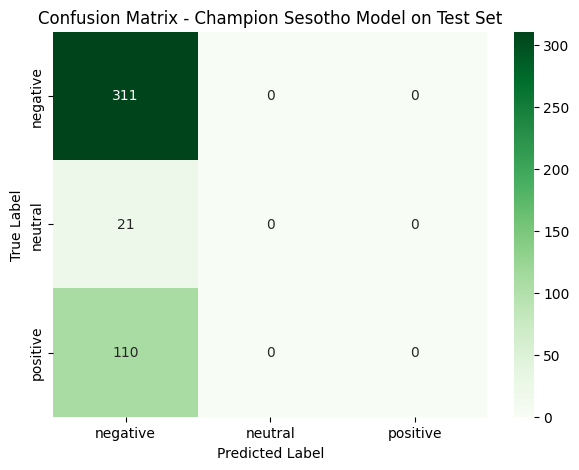

In [60]:
# @title M.3: Predictions & Confusion Matrix (Champion Sesotho Model)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


if 'model_champ_shap' in locals() and model_champ_shap and \
   'tokenizer_champ_shap' in locals() and tokenizer_champ_shap and \
   'sesotho_test_texts_for_shap_final' in locals() and len(sesotho_test_texts_for_shap_final) > 0:

    print(f"\n--- Generating predictions for ORIGINAL NEW Sesotho test set using CHAMPION model ---")
    print(f"(Model: AfriBERTa Full FT + Augmentation, loaded from: {CHAMPION_MODEL_CHECKPOINT_PATH})")

    # Ensures pipeline is available (it's defined in M_Champ_2)
    if 'champ_sentiment_pipeline' not in locals():
        print("Re-initializing TextClassificationPipeline for predictions...")
        pipeline_device_champ = 0 if torch.cuda.is_available() else -1
        champ_sentiment_pipeline = TextClassificationPipeline(
            model=model_champ_shap, tokenizer=tokenizer_champ_shap,
            device=pipeline_device_champ, return_all_scores=False
        )

    try:
        # Get predictions (pipeline with return_all_scores=False returns list of dicts like [{'label': 'X', 'score': Y}])
        pipeline_preds_list = champ_sentiment_pipeline(sesotho_test_texts_for_shap_final, padding=True, truncation=True)
        predicted_labels_as_text_champ = [pred[0]['label'] for pred in pipeline_preds_list]

        y_pred_champ_numeric = [label2id_champ_shap[text_label] for text_label in predicted_labels_as_text_champ]
        y_true_champ_numeric = sesotho_test_labels_for_shap_final

        print("\n--- Classification Report for CHAMPION Sesotho Model on Test Set ---")
        target_names_champ_report = [id2label_champ_shap[i] for i in sorted(id2label_champ_shap.keys())]
        print(classification_report(y_true_champ_numeric, y_pred_champ_numeric, target_names=target_names_champ_report, zero_division=0))

        print("\n--- Confusion Matrix for CHAMPION Sesotho Model ---")
        cm_champ = confusion_matrix(y_true_champ_numeric, y_pred_champ_numeric, labels=sorted(id2label_champ_shap.keys()))
        plt.figure(figsize=(7,5))
        sns.heatmap(cm_champ, annot=True, fmt='d', cmap='Greens',
                    xticklabels=target_names_champ_report,
                    yticklabels=target_names_champ_report)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix - Champion Sesotho Model on Test Set')
        plt.show()

    except Exception as e_cm:
        print(f"Error during prediction or confusion matrix generation for champion model: {e_cm}")
        import traceback
        traceback.print_exc()
else:
    print("Prerequisites for generating confusion matrix for Champion Sesotho model not met.")